# Facial Keypoint Detection

## Authors: Stone Jiang, Louis Li, Delon Saks
    
Special thanks for Erkas Tas for writing the conclusions.

Facial keypoints labeling is an important and challenging problem in computer vision. At inference time, we would like to take as input the pixel representation of an image of a face, and output the locations of various landmarks, including the position on and around the eye and lips, and the tip of the nose.

The ability to accurately label these locations enables numerous downstream applications. These include facial recognization, analysis of facial expressions, detecting dysmorphic facial signs for medical diagnosis, biometrics, and facial tracking in videos. For example, the analysis of facial expressions can be done by measuring the shape of the lips, where curving up might represent a smiles and curving down might represent a frown. This analysis could be important for classifying true customer satisfaction of a transaction at a retail store or a driver's mood in a car.

Detecing facial keypoints is a very challenging problem. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement. The variability of facial features from individual to individual, the diversity in angles from which pictures are taken, and the scale of the facial image with respect to the rest of the picture are three challenges that make accurate labeling difficult in practice. The goal of this project is develop a machine learning model to address this problem, including the state-of-the-art convolutional neural networks. 

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3486/logos/front_page.png" style="height:300px"> 



### DATA

In this Kaggle competition, each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

- **left_eye_center** 
- **right_eye_center**
- **left_eye_inner_corner**
- **left_eye_outer_corner**
- **right_eye_inner_corner**
- **right_eye_outer_corner**
- **left_eyebrow_inner_end**
- **left_eyebrow_outer_end**
- **right_eyebrow_inner_end**
- **right_eyebrow_outer_end**
- **nose_tip**
- **mouth_left_corner**
- **mouth_right_corner**
- **mouth_center_top_lip**
- **mouth_center_bottom_lip**

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

The input is an 96x96 image, or 9216 vector. Because the output is 15 pairs of position (x,y), we consider this is a regression problem. The output of the model would be a 15x2 matrics, which can also be a 30 vector.

Data files:

**training.csv**: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.

**test.csv**: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels

**submissionFileFormat.csv**: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict.

Data downloaded directly from Kaggle, and was initially supplied by Dr. Yoshua Bengio of the University of Montreal.

https://www.kaggle.com/c/facial-keypoints-detection

### EVALUATION
Root Mean Squared Error (RMSE)
Submissions are scored on the root mean squared error. RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors:
$$
RMSE=\sqrt{\frac{\sum_{i=1}^{n}(y_i−y^i)^2}{n}}
$$
where y hat is the predicted value and y is the original value.

Kaggle site: https://www.kaggle.com/c/facial-keypoints-detection/overview 

## METHODS AND INFERENCE

The problem we have at hand is a regression problem. Given the pixels of an image as features, we would like to build a model that maps these features to the location of facial landmarks on a continuous scale from 0 - 96, in both the x and y directions. Our primary model will be a Convolutional Neural Network. Our error analysis, feature engineering and hyperparameters optimization will focus around this.

In addition, we have benchmarked method we've learned in this course that has a natural translation in the regression context. This includes k-Nearest Neighbors, Linear Regression, Ridge Regression, Decision Tree Regressor, Random Forest Regressor, and Neural Network regression. Results are shown in the appendix. These models will all operate on a flattened representation of the image as its features. 

# OUR APPROACH

Given this is an image based problem, we decided to use Convolunational Network to capture the features of images, then use linear regression to output 30 vectors. 

In choosing a CNN network, we started with build and training a relatively simple network inspired by LeNet, shown below.

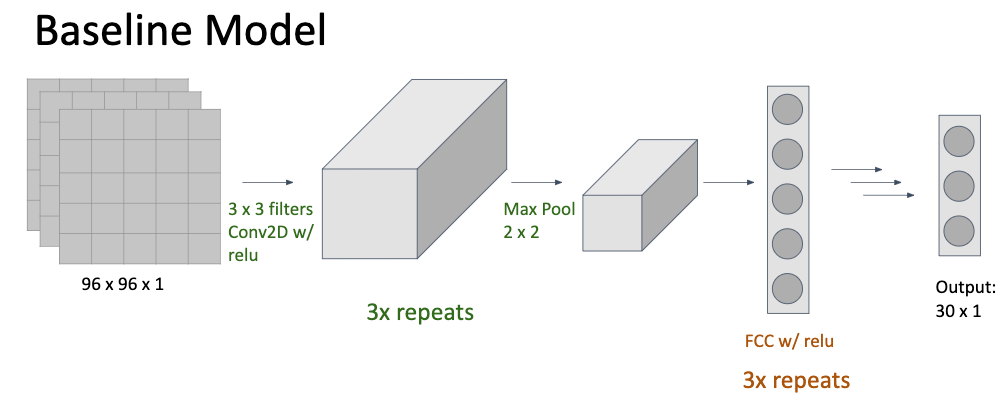

In [1]:
from IPython.display import Image
Image("pics/base_model.png")

This architecture was used as a baseline to test various different data augmentation strategies. The training data set included many images with poorly labeled data, and therefore for the first several iterations of the model we decided to focus only on that portion of the training data that did not contain missing labels. The various different types of data augmentation are described further in the report.

As a means of incorporating the full training data set we decided, after the first several iterations, to incorporate an iterative algorithm, as described below:

1. Train model using only images with no missing labels, and predict on partially labeled images
2. Take only images for which RMSE between the provided partial labels and the corresponding predicted labels is low.
3. Reconstruct these images such that we first keep the provided labels, and use the predicted labels for the rest of the keypoints which were not supplied.
4. Further refine and train the network using early stopping.

Several other methodologies were tested, including:
- Cross validation with 10 partitions
- Transfer learning using a pretrained weights from DenseNet 201

A final, inspired by Resnet, was implemented after Error Analysis and model comparison. Below is the Resnet architecture:

<img src="https://www.researchgate.net/publication/331364877/figure/fig3/AS:741856270901252@1553883726825/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be_W640.jpg" style="height:500px"> 
Source: 
<a href="https://www.researchgate.net/publication/331364877_Optimized_Deep_Convolutional_Neural_Networks_for_Identification_of_Macular_Diseases_from_Optical_Coherence_Tomography_Images">Optimized Deep Convolutional Neural Networks for Identification of Macular Diseases from Optical Coherence Tomography Images</a>

After trying many different transfer learning models, our best-performing, final network architecture is depicted below:

<img src="https://img.techpowerup.org/200412/resnet-network.png" style="height:400px"> 

### Disclaimer:

In the code provided in this notebook, we have intentionally reduced the steps_per_epoch and iterations so our code will be able to complete execution within a reasonable time. The models we have built, especially the final model, had been trained on a GPU VM for a few days to achieve the best result possible. If you have any questions or would like to examine the trained model used for Kaggle competition, please see the weights files in our github repository:

https://github.com/siduojiang/w207_final_project_saks_li_jiang

## EXPLORATORY DATA ANALYSIS

## Library and Data Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
from matplotlib.patches import Ellipse
import seaborn as sns
import random
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.ndimage import gaussian_filter

# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import applications,optimizers, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, Callback

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
from imgaug import parameters as iap

import dill

warnings.filterwarnings('ignore')


tf.random.set_seed(0)
np.random.seed(0) 

## Data Processing

In [3]:
from utils.preprocessing import KaggleDataProcessor
from utils.eda import visualize_data, plot_keypoint_matrix

#Process data from Kaggle -- see corresponding function
data = KaggleDataProcessor()

Not all images have all keypoints labeled. Below is the number of images with labeled points for each landmark. We can see that most images have eyes, nose and bottom lip, but more than two-thirds lack labels for the other features. 

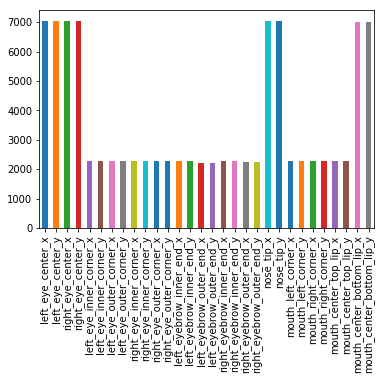

In [4]:
data.full_training_data.describe().loc['count'].plot.bar()

We can clearly see that a large number of labels are missing, and we have a few options to mitigate for the missing labels:
1. Amputate data with missing labels, and only work with images that are fully labeled.
2. Use labels as they are and ignore missing labels. This could harm the model prediction on the positions where there are missing labels.

For now, we will only consider all images with fully labeled keypoints. The partially labeled images will play a key role later in further optimization. We can call the following to visualize only fully labeled data.

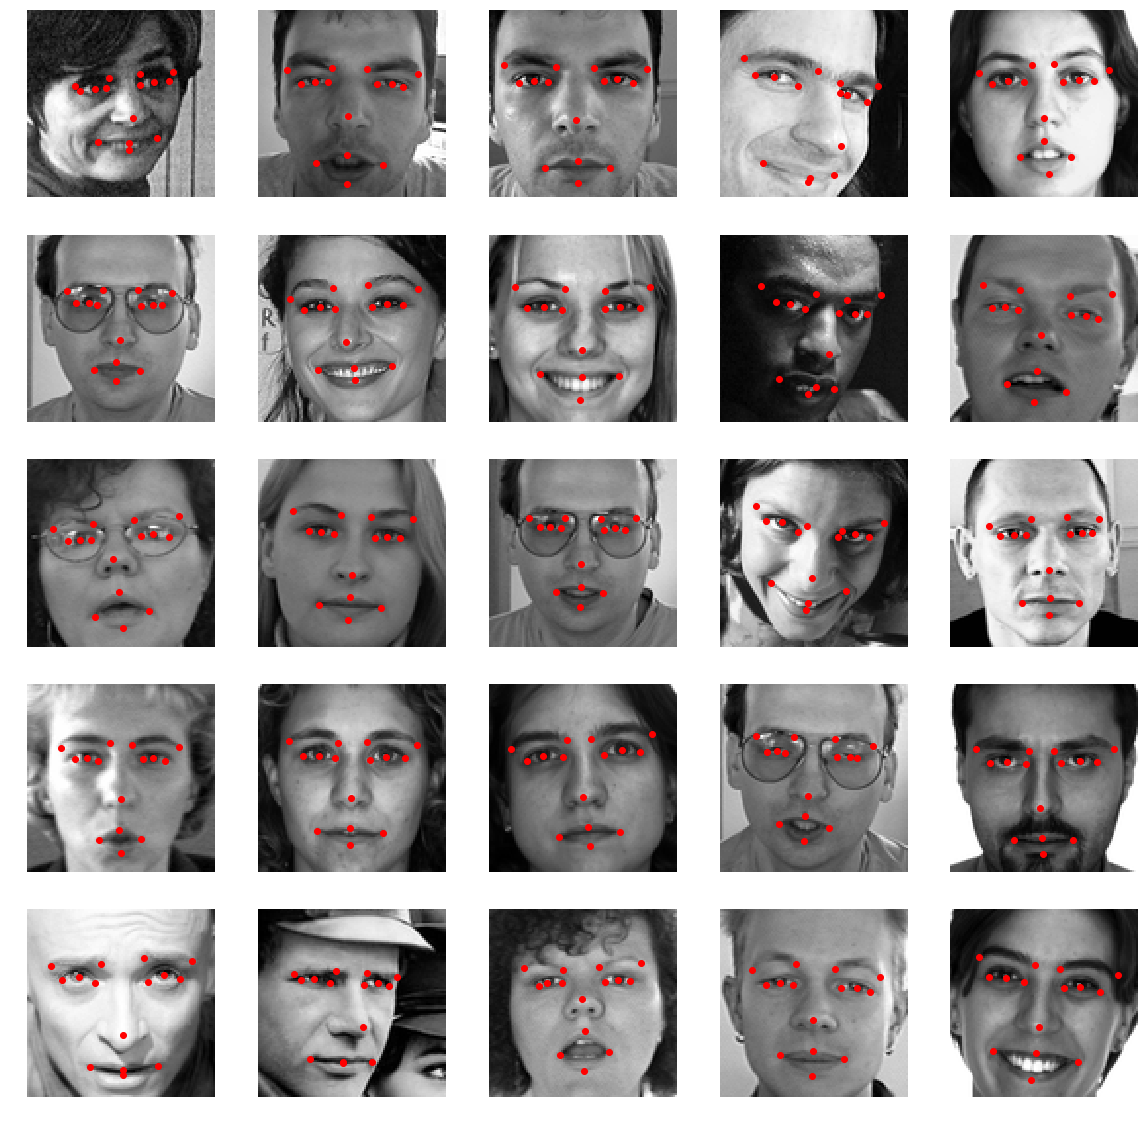

In [5]:
#Draw random group of faces from the training set and label the keypoints
full_data_nonmissing, train_dev_data, train_labels_full = data.get_nonmissing_data()
visualize_data(full_data_nonmissing)

### Mislabels

We output all images to disk and examined the images with labels. We found that there are mislabelled images such as the 16 presented below. These images will be eliminated from the training and development process.

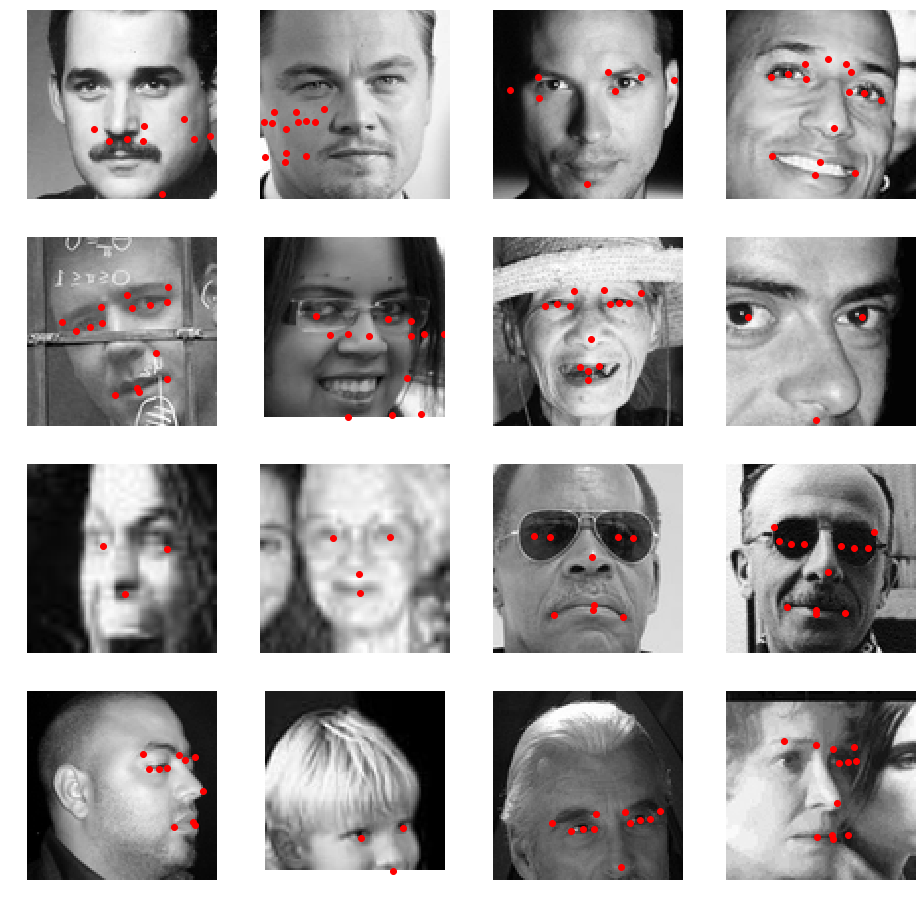

In [6]:
#Visualize matrix of mislabeled images
mask = np.array([1877, 1907, 1747, 1995, 1926, 2199, 2202, 2289, 2321, 2461, 1956, 1741, 2175, 2453,1881,2090 ])

visualize_data(data.full_training_data, num = 4, mask = mask)

Finally, we visualize the distribution of keypoints based on x,y coordinates for all images. This allows us to get a sense of the variance of these keypoints for our labeled data set.

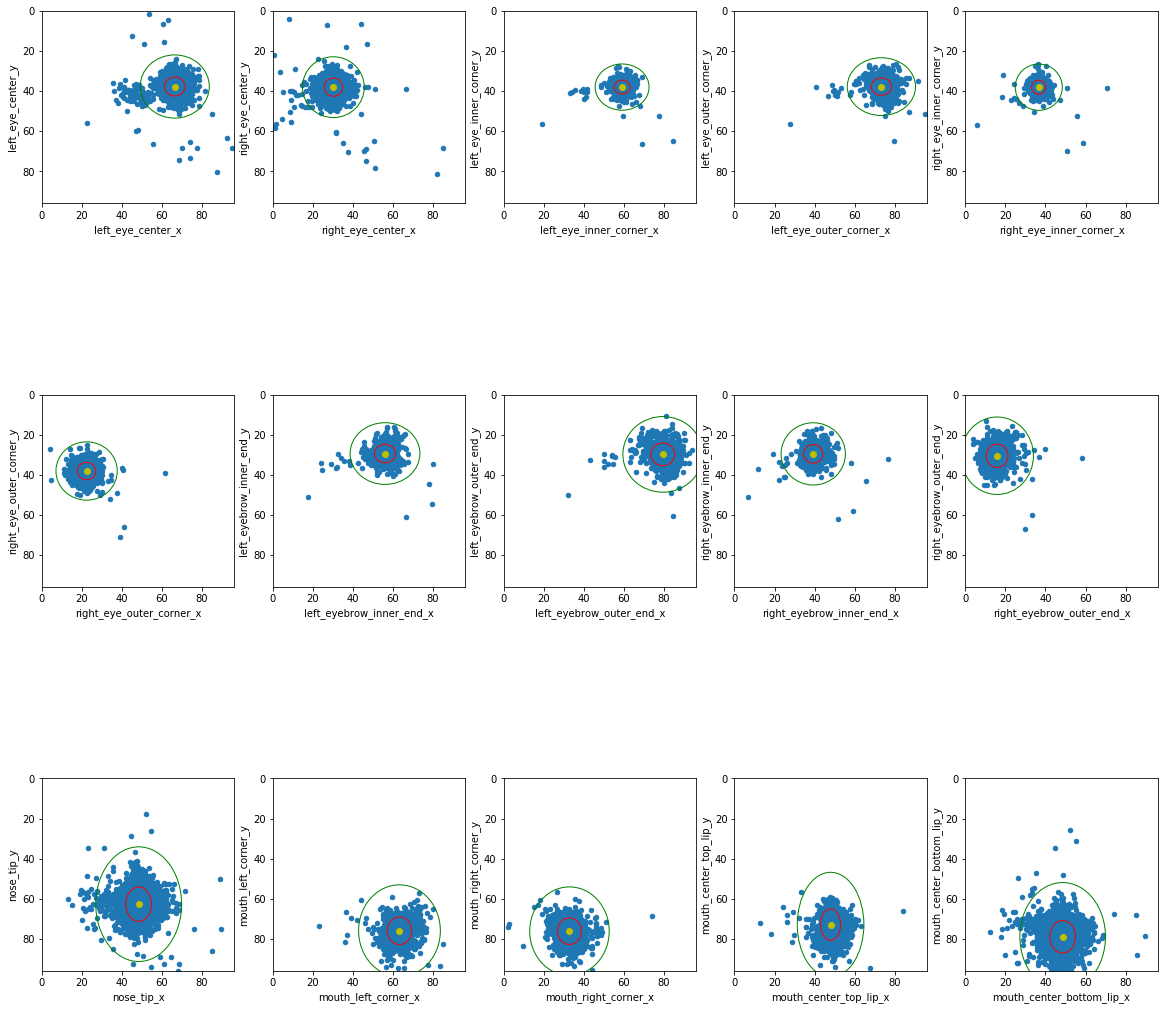

In [7]:
plot_keypoint_matrix(data.full_training_data)

If we dropping mislabled images, as well as images with only partial labels, the spread for each keypoint is much smaller:

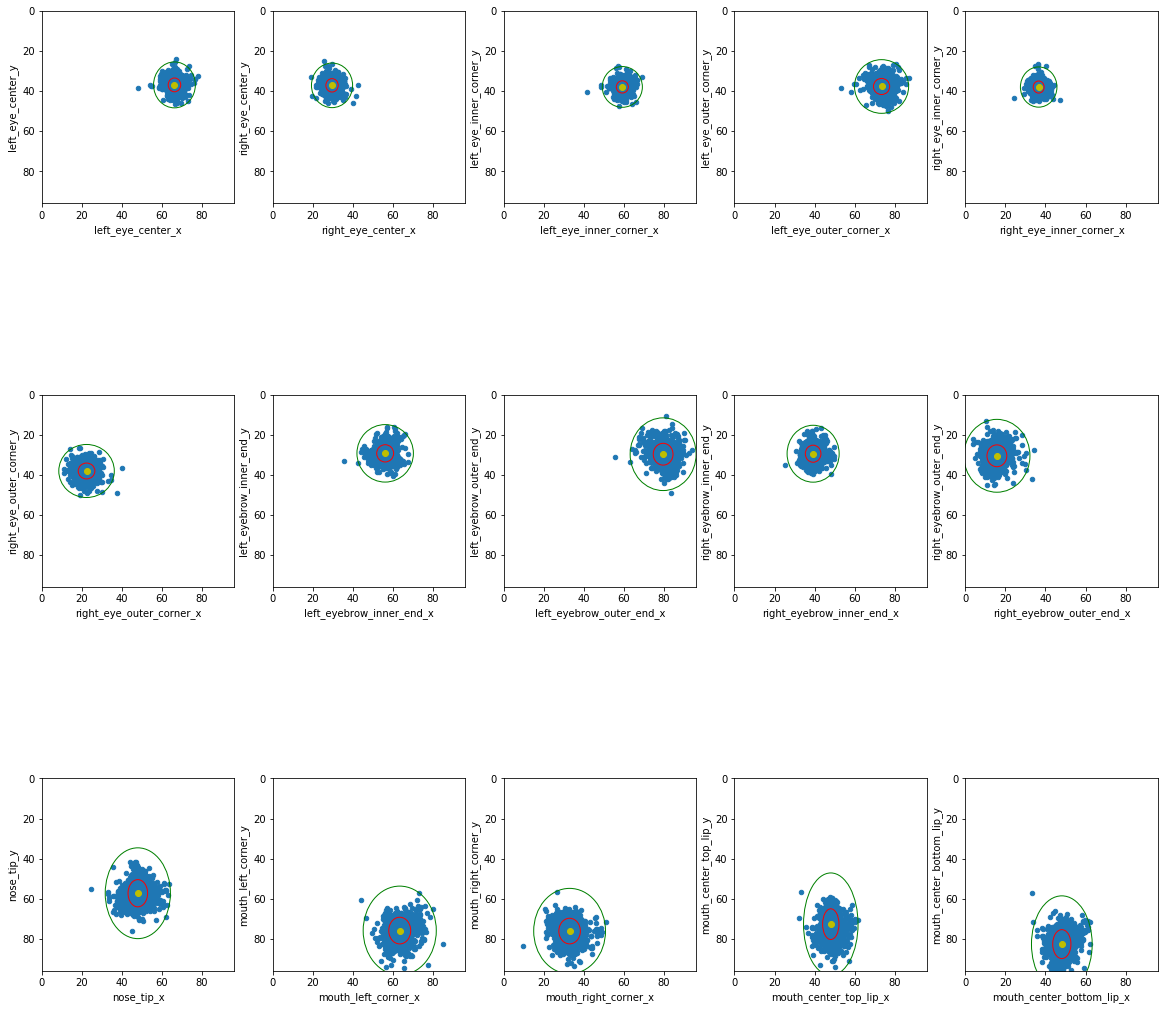

In [8]:
plot_keypoint_matrix(data.full_training_data.drop(mask).dropna())

This means the fully labelled data is only a subset of training data and we will need to work with partially labelled data to be able to achieve better result. 

### Data train/dev/test split

We will separate our dataset into 3 sets, train (80% of the data), dev (~18% of the data) and test (~2% of the data). The training data will be used to fit the parameters of our model. The dev data will be used for hyperparameter optimization, such as early stopping, types and number of network layers, etc. The test set used to evaluate on the performance of our selected models, as our best tool for measuring generalization, and what we might expect when we submit to Kaggle. We provide corresponding functions in the utils package to do this. However, in order to have full reproducibility of the model scores below, we will upload images based on the original split that the models were trained on. These are stored as npy and npz files below.

In [9]:
loaded = np.load('data/train_images.npz')
train_data = loaded['train_data']
dev_data = np.load('data/dev_images.npy')
test_split_data = np.load('data/test_split_images.npy')
train_labels = np.load('data/train_labels.npy')
dev_labels = np.load('data/dev_labels.npy')
test_split_labels = np.load('data/test_split_labels.npy')

# BASELINE MODELS

A collection of non-neural network based baseline models were trained, and these can be found in the appendix. However, the performance of these models were sub-par to our baseline CNN presented below.

## CONVOLUTIONAL NEURAL NETWORK

The state of the art for image processing is a convolutional neural network (CNN). The one we fit below is inspired a classic architecture where (LeNet). As we go deeper into the convoluational layers, we increase the depth of the image (number of channels) while shrinking the height and width. The effect of this is that more diverse features can be captured by having deeper layers while condensing down irrelevant features. We feed the convoluational layers to fully-connected layers at the end of the network in order to make continuous predictions. 

In [10]:
from models.models import *

def prediction_errors_with_test(model, pr = True, save = None):
    '''Helper function to calculate prediction errors. Can also save out model to specified path'''

    #First generate all predictions on the train, dev and test sets
    test_predictions = model.predict(test_split_data.reshape(test_split_data.shape[0], 96, 96, 1))
    predictions = model.predict(dev_data.reshape(dev_data.shape[0], 96, 96, 1))
    train_predictions = model.predict(train_data.reshape(train_data.shape[0], 96, 96, 1))

    #Calculate the mean squared error for each of the data sets
    test_error = mean_squared_error(test_split_labels, test_predictions)
    train_error = mean_squared_error(train_labels, train_predictions)
    dev_error = mean_squared_error(predictions, dev_labels)

    #Print the train, dev, and test errors
    if pr:
        print("Train RMSE:", train_error)
        print("Dev RMSE:", dev_error)
        print("Test RMSE:", test_error)

    if save:
        model.save(save)

    return train_error, dev_error, test_error

### Model Training

This model is fast to train on a GPU, so we will show the full training history. For other models below, we will show the code, and upload the pre-trained weights to show the errors.

In [96]:
model = model_lenet_inspired()

#Print a summary of the model
model.summary()

#Train the model
training_history = model.fit(np.expand_dims(train_data, axis = 3), train_labels,
                             validation_data = (np.expand_dims(dev_data, axis = 3), dev_labels),
                             epochs=1000,
                             batch_size=128,
                             #shuffle=True,
                             callbacks = [BestValidationModel()])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 6400)            

Epoch 134/1000
1538/1538 [==============================] - 1s 335us/sample - loss: 4.7407 - val_loss: 8.9653
Epoch 135/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 5.7370 - val_loss: 5.3211
Epoch 136/1000
1538/1538 [==============================] - 1s 332us/sample - loss: 5.1188 - val_loss: 4.7690
Epoch 137/1000
1538/1538 [==============================] - 1s 334us/sample - loss: 4.7580 - val_loss: 5.1691
Epoch 138/1000
1538/1538 [==============================] - 1s 345us/sample - loss: 4.6271 - val_loss: 4.8559
Epoch 139/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 4.4984 - val_loss: 8.0182
Epoch 140/1000
1538/1538 [==============================] - 1s 339us/sample - loss: 5.6603 - val_loss: 9.2898
Epoch 141/1000
1538/1538 [==============================] - 1s 333us/sample - loss: 5.5867 - val_loss: 4.6676
Epoch 142/1000
1538/1538 [==============================] - 1s 354us/sample - loss: 4.4591 - val_loss: 4.5318
Epoch 143/

1538/1538 [==============================] - 1s 347us/sample - loss: 2.6544 - val_loss: 3.8591
Epoch 283/1000
1538/1538 [==============================] - 1s 340us/sample - loss: 2.7626 - val_loss: 2.9353
Epoch 284/1000
1538/1538 [==============================] - 1s 334us/sample - loss: 2.4510 - val_loss: 3.1051
Epoch 285/1000
1538/1538 [==============================] - 1s 338us/sample - loss: 2.4304 - val_loss: 3.3213
Epoch 286/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 2.5938 - val_loss: 2.9387
Epoch 287/1000
1538/1538 [==============================] - 1s 339us/sample - loss: 2.4343 - val_loss: 3.1326
Epoch 288/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 2.5953 - val_loss: 3.0985
Epoch 289/1000
1538/1538 [==============================] - 1s 335us/sample - loss: 2.4344 - val_loss: 3.9846
Epoch 290/1000
1538/1538 [==============================] - 1s 333us/sample - loss: 2.8542 - val_loss: 9.3516
Epoch 291/1000
1538/1538 

1538/1538 [==============================] - 1s 340us/sample - loss: 1.9443 - val_loss: 3.7820
Epoch 431/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 1.9193 - val_loss: 3.3203
Epoch 432/1000
1538/1538 [==============================] - 1s 339us/sample - loss: 1.8542 - val_loss: 4.1824
Epoch 433/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 2.2343 - val_loss: 2.7098
Epoch 434/1000
1538/1538 [==============================] - 1s 338us/sample - loss: 1.8902 - val_loss: 2.6575
Epoch 435/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 1.6787 - val_loss: 2.6470
Epoch 436/1000
1538/1538 [==============================] - 1s 336us/sample - loss: 1.6004 - val_loss: 2.6179
Epoch 437/1000
1538/1538 [==============================] - 1s 338us/sample - loss: 1.5119 - val_loss: 2.9005
Epoch 438/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 1.6385 - val_loss: 3.0691
Epoch 439/1000
1538/1538 

1538/1538 [==============================] - 1s 337us/sample - loss: 0.9511 - val_loss: 2.3852
Epoch 579/1000
1538/1538 [==============================] - 1s 338us/sample - loss: 0.9041 - val_loss: 2.8126
Epoch 580/1000
1538/1538 [==============================] - 1s 340us/sample - loss: 1.1307 - val_loss: 2.4274
Epoch 581/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 0.9237 - val_loss: 2.4900
Epoch 582/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 0.9598 - val_loss: 2.3353
Epoch 583/1000
1538/1538 [==============================] - 1s 340us/sample - loss: 0.8903 - val_loss: 2.4004
Epoch 584/1000
1538/1538 [==============================] - 1s 342us/sample - loss: 0.8302 - val_loss: 2.8697
Epoch 585/1000
1538/1538 [==============================] - 1s 341us/sample - loss: 1.1453 - val_loss: 2.4529
Epoch 586/1000
1538/1538 [==============================] - 1s 336us/sample - loss: 0.8761 - val_loss: 2.9871
Epoch 587/1000
1538/1538 

1538/1538 [==============================] - 1s 335us/sample - loss: 0.5771 - val_loss: 2.3968
Epoch 727/1000
1538/1538 [==============================] - 1s 340us/sample - loss: 0.5741 - val_loss: 2.2937
Epoch 728/1000
1538/1538 [==============================] - 1s 336us/sample - loss: 0.5194 - val_loss: 2.3718
Epoch 729/1000
1538/1538 [==============================] - 1s 343us/sample - loss: 0.5583 - val_loss: 2.6210
Epoch 730/1000
1538/1538 [==============================] - 1s 340us/sample - loss: 0.6955 - val_loss: 2.6952
Epoch 731/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 0.8734 - val_loss: 2.3802
Epoch 732/1000
1538/1538 [==============================] - 1s 338us/sample - loss: 0.6484 - val_loss: 2.5646
Epoch 733/1000
1538/1538 [==============================] - 1s 342us/sample - loss: 0.7056 - val_loss: 2.8231
Epoch 734/1000
1538/1538 [==============================] - 1s 338us/sample - loss: 0.7711 - val_loss: 3.4765
Epoch 735/1000
1538/1538 

1538/1538 [==============================] - 1s 340us/sample - loss: 0.6605 - val_loss: 2.6051
Epoch 875/1000
1538/1538 [==============================] - 1s 339us/sample - loss: 0.4379 - val_loss: 2.6628
Epoch 876/1000
1538/1538 [==============================] - 1s 343us/sample - loss: 0.4485 - val_loss: 2.4770
Epoch 877/1000
1538/1538 [==============================] - 1s 343us/sample - loss: 0.3737 - val_loss: 2.3883
Epoch 878/1000
1538/1538 [==============================] - 1s 339us/sample - loss: 0.3489 - val_loss: 2.3977
Epoch 879/1000
1538/1538 [==============================] - 1s 340us/sample - loss: 0.3649 - val_loss: 2.5957
Epoch 880/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 0.5198 - val_loss: 2.6531
Epoch 881/1000
1538/1538 [==============================] - 1s 347us/sample - loss: 0.5145 - val_loss: 2.4018
Epoch 882/1000
1538/1538 [==============================] - 1s 337us/sample - loss: 0.4641 - val_loss: 2.6373
Epoch 883/1000
1538/1538 

Train RMSE: 0.5374915597111395
Dev RMSE: 2.271569362930424
Test RMSE: 3.2870102805838965


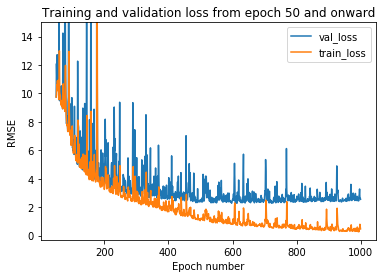

In [97]:
x = np.arange(len(training_history.history['val_loss'][50:])) + 50
plt.plot(x, training_history.history['val_loss'][50:], label = 'val_loss')
plt.plot(x, training_history.history['loss'][50:], label = 'train_loss')
plt.ylim([-0.3, 15])
plt.title("Training and validation loss from epoch 50 and onward", fontsize = 12)
plt.xlabel("Epoch number")
plt.ylabel("RMSE")
plt.legend()

training_error, dev_error, test_error = prediction_errors_with_test(model)

Based on the training and dev errors, since there is a large discrepancy (~1.76 RMSE) we appear to be overfitting to the training set. In addition, the test set error is about 1 RMSE larger than the dev set error, suggesting that the model we selected, which had the best dev error from 1000 training epochs, did not generalize well to a separate test set. Below we plot some of the images on which we performed poorly.

### Error Analysis for the Baseline Model

In [34]:
from utils.evaluation import plot_train_data_errors

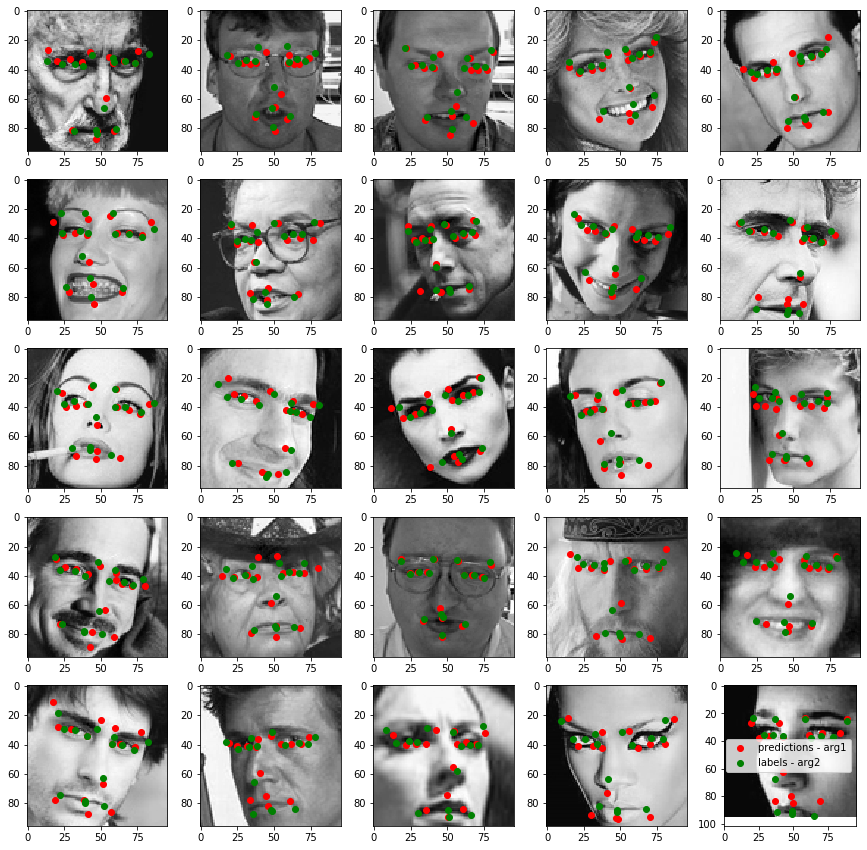

In [99]:
#Plot the 25 worst dev set predictions
dev_predictions = base_model.predict(np.expand_dims(dev_data, axis = 3))
dev_rmses = np.array([mean_squared_error(dev_predictions[i], dev_labels[i]) for i in np.arange(len(dev_predictions))])
order = np.argsort(dev_rmses)
ranges = order[-25:]
plot_train_data_errors(dev_data[ranges], dev_predictions[ranges], dev_labels[ranges], True)

A few trends emerge from images above. In the training set, some of the images are blurred. An example is last row image 2, where the entire face is blurred and features difficult to distinguish even by eye. In the dev set, many of the images are of sideways faces, such as last to second row image 3. Adding sideways images into the training set could help.

## Augmented Data Model 1

In order to increase the diversity of the training set with the hope of improving generalization error, we will apply a common image processing technique known as data augmentation. By applying transformations to existing images, we can artificially increase the diversity of the training set while preserving the keypoints during the transformation. Many types of techinques for doing this exists, including cropping, flipping, blurring, etc., and we will apply several of these as part of our feature engineering efforts. An example will be demonstrated below.

### Data Augmentation and Feature Engineering

As part of our image feature engineering efforts, the augmentation technique we implement manually is vertical flipping. Here, we take the mirror image of the image across the y-axis, while transforming the key points.

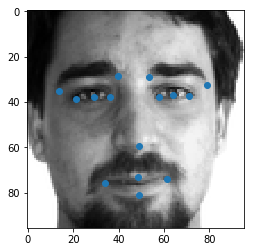

In [11]:
#Generate an example image
image = train_data[5]
label = train_labels[5]
plt.imshow(image, cmap = 'gray')
plt.scatter(*train_labels[5].reshape(15,2).T)

In [12]:
#Horizontally flip the image
new_image = image[:, np.arange(1,96,1)[::-1]]
new_label_x = 96 - label.reshape(15,2).T[0]
new_label_y = label.reshape(15,2).T[1]

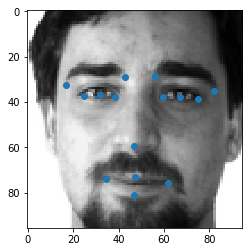

In [13]:
plt.imshow(new_image, cmap = 'gray')
digit = 14
plt.scatter(new_label_x, new_label_y)

In [14]:
#Vectorize across all images, and add then to the train data

new_train_data = train_data[:, :, np.arange(0,96,1)[::-1]]
new_train_labels = np.zeros(train_labels.shape)

#new order of the label pairs; right eye becomes left eye, etc.
#This step is important because when images are flipped and keypoints are mirrored,
#    the left side of the face will now be considered the right size of the face.
#The following list is the new order of keypoint pairs.
new_order = np.array([1, 0, 4, 5, 2,
                      3, 8, 9, 6, 7,
                      10, 12, 11, 13, 14])

for i,label in enumerate(train_labels):
    new_label_x = 96 - label.reshape(15,2).T[0][new_order]
    new_label_y = label.reshape(15,2).T[1][new_order]
    new_label = np.vstack([new_label_x, new_label_y]).T.ravel()
    
    new_train_labels[i] = new_label

print(new_train_data.shape)
print(new_train_labels.shape)

#Generate the augmented data set by stacking training data with vertically flipped training data
train_data_augmented = np.vstack([train_data, new_train_data])
train_labels_augmented = np.vstack([train_labels, new_train_labels])

(1538, 96, 96)
(1538, 30)


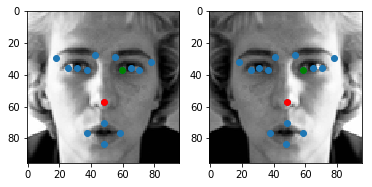

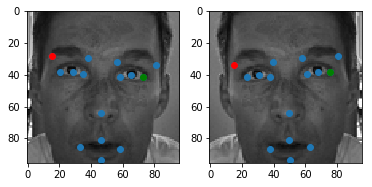

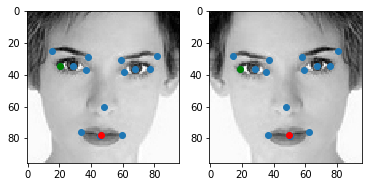

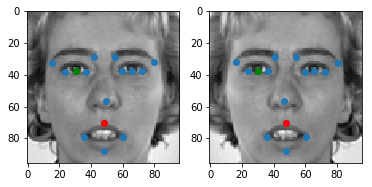

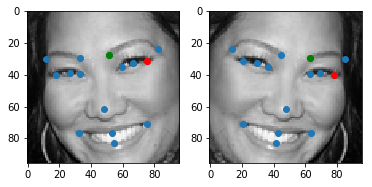

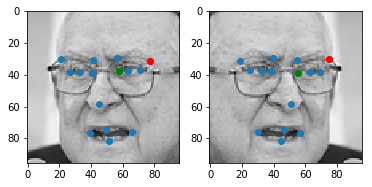

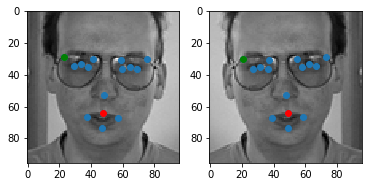

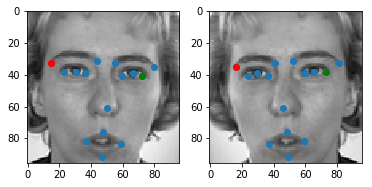

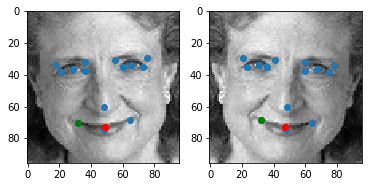

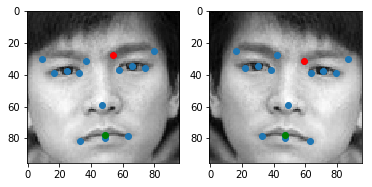

In [15]:
#Generate pairs to visually see if the images look correct
pair = np.random.choice(np.arange(len(train_data)), 10, replace = False)

for p in pair:
    ax = plt.subplot(1,2,1)
    image = train_data_augmented[p]
    label = train_labels_augmented[p]
    ax.imshow(image, cmap = 'gray')
    ax.scatter(*label.reshape(15,2).T)

    #add a red and green point to show that the location orders are correct
    (dig1, dig2) = np.random.choice(np.arange(0,15), size = 2, replace = False)
    ax.scatter(label.reshape(15,2).T[0][dig1], label.reshape(15,2).T[1][dig1], c = 'r')
    ax.scatter(label.reshape(15,2).T[0][dig2], label.reshape(15,2).T[1][dig2], c = 'g')

    ax = plt.subplot(1,2,2)
    image = train_data_augmented[p+train_data.shape[0]]
    label = train_labels_augmented[p+train_data.shape[0]]
    ax.imshow(image, cmap = 'gray')
    ax.scatter(*label.reshape(15,2).T)

    #add a red and green point to show that the location orders are correct
    ax.scatter(label.reshape(15,2).T[0][dig1], label.reshape(15,2).T[1][dig1], c = 'r')
    ax.scatter(label.reshape(15,2).T[0][dig2], label.reshape(15,2).T[1][dig2], c = 'g')

    plt.show()

### Model Training

We will now train the same model with the augmented training data that includes the flipped images.

In [16]:
model_2 = model_lenet_inspired()
#Code will not be run each time
# training_history_model_2 = model_2.fit(np.expand_dims(train_data_augmented, axis = 3), train_labels_augmented,
#                              validation_data = (np.expand_dims(dev_data, axis = 3), dev_labels),
#                              epochs=1000,
#                              batch_size=128,
#                              #shuffle=True,
#                              callbacks = [BestValidationModel()])

In [17]:
#Weights are pre-trained and loaded below
model_2 = model_lenet_inspired()
model_2.load_weights('weights/model2.h5')

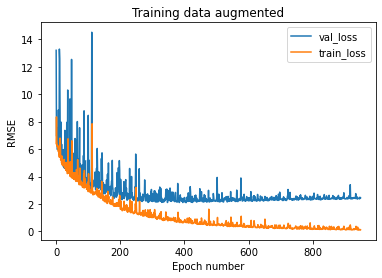

In [18]:
Image('pics/training_data_augmented.png')

In [19]:
training_error, dev_error, test_error = prediction_errors_with_test(model_2)

Train RMSE: 0.594819809399288
Dev RMSE: 2.09682537729171
Test RMSE: 2.8892730589912494


With added training data, we are still overfitting; however, the dev and test errors have both decreased. The conclusion is that adding data vertically flipped data helps slightly, but the diversity of information introduced is likely not enough. To get around this, we will greatly increase the diversity of our augmented set. In addition as demonstrated above, if the added data is static, with enough epochs, we will still overfit. To potentially get around this, we will augment the training images on the fly during the fitting step, so that every epoch sees new data. Keras supports this through a data generator object.

## Augmented Data Model 2

### Further Data Augmentation

The previous augmentation model indeed led to an improvement. However, we were still overfitting to the train, so we increase the diversity of augmentation further using more advanced techniques than verticle flipping. We will use imgaug for further image augmentation, since this package will also keep keypoints invariant. An example of some of the images below generated by image augmentation.

In [20]:
from image_aug.aug_tools import *

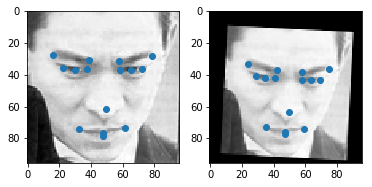

In [21]:
train_aug_test_gen = train_generator(train_data, train_labels, batch_size=10, single_batch=True)
train_aug_test = next(train_aug_test_gen)
ax = plt.subplot(121)
ax.imshow(train_data[1].reshape(96,96), cmap = 'gray')
ax.scatter(*train_labels[1].reshape(15,2).T)
ax = plt.subplot(122)
ax.imshow(train_aug_test[0][11].reshape(96,96), cmap = 'gray')
ax.scatter(*train_aug_test[1][11].reshape(15,2).T)

### Model Training

Rather the building a pre-augmented dataset as in Augmented Data Model 1, we will now fit the model by augmenting training data on the fly. This way, each epoch of training sees differently augmented images. Due to the way we've written the augmentation code, each epoch will be training on the original image, and 5 different augmentations of the original image. 

In [22]:
#Train the model to establish baseline
#Note that the fit function is now taking the train generator
model_3 = model_lenet_inspired()
# training_history_model_augmented_2 = model_3.fit(train_generator(train_data_augmented, train_labels_augmented),
#                              validation_data = (np.expand_dims(dev_data_augmented, axis = 3), dev_labels_augmented),
#                              epochs=1000,
#                              steps_per_epoch = 26,
#                              #shuffle=True,
#                              callbacks = [BestValidationModel()])

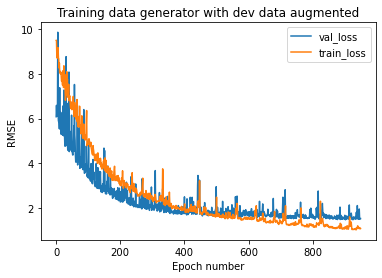

In [23]:
Image('pics/training_data_with_generator.png')

In [24]:
model_3.load_weights('weights/model3.h5')
train_error, dev_error, test_error = prediction_errors_with_test(model_3)

Train RMSE: 0.39400342796353904
Dev RMSE: 1.4454438107201952
Test RMSE: 1.7486744719241447


The performance looks fairly good. At this point, we evalulated the model on Kaggle, which returned an RMSE of 2.97. This means that there's distribution differences between the dev/test data that we have here, and the test data on the Kaggle site. In order to get around this, we tried increasing the diversity of images in the dev set with the hope of capturing some of the features in the test set. In other words, we wanted to generate a test set that we could trust.

## Augmented Data Model 3

### Dev Data Augmentation

In order develop a model that better generalizes to the Kaggle test set, we will generate a larger dev set with hope that this augmented dev set will contains more of the features found on the Kaggle test set. This way, we may be able to select a model with better generalization. Due to speed restrictions, the dev set will be static (training with a dev generator is very slow).

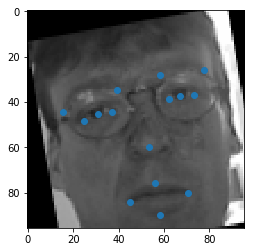

In [25]:
#Generate a fully labeled and augmented dev set
new_dev_data = dev_data[:, :, np.arange(0,96,1)[::-1]]
new_dev_labels = np.zeros(dev_labels.shape)

#new order of the label pairs; right eye becomes left eye, etc.
new_order = np.array([1, 0, 4, 5, 2,
                      3, 8, 9, 6, 7,
                      10, 12, 11, 13, 14])

for i,label in enumerate(dev_labels):
    new_label_x = 96 - label.reshape(15,2).T[0][new_order]
    new_label_y = label.reshape(15,2).T[1][new_order]
    new_label = np.vstack([new_label_x, new_label_y]).T.ravel()
    
    new_dev_labels[i] = new_label

#These will include the vertically flipped images
dev_data_augmented = np.vstack([dev_data, new_dev_data])
dev_labels_augmented = np.vstack([dev_labels, new_dev_labels])

#Now, use image_aug to generate 5x augmented dev set
dev_data_iaa, dev_labels_iaa = image_aug(dev_data_augmented, dev_labels_augmented)
digit = np.random.choice(np.arange(dev_data_iaa.shape[0]))
plt.imshow(dev_data_iaa[digit].reshape(96,96), cmap = 'gray')
plt.scatter(*dev_labels_iaa[digit].reshape(15,2).T)
dev_data_augmented = dev_data_augmented.reshape(-1,96,96)
new_dev_data_augmented = np.expand_dims(np.copy(dev_data_augmented), axis = 3)
new_dev_labels_augmented = np.copy(dev_labels_augmented)

for i in range(5):
    dev_data_iaa, dev_labels_iaa = image_aug(dev_data_augmented, dev_labels_augmented)
    new_dev_data_augmented = np.vstack([new_dev_data_augmented, dev_data_iaa])
    new_dev_labels_augmented = np.vstack([new_dev_labels_augmented, dev_labels_iaa])

We also explored various model parameters to ameliorate overfitting. The model found below, which has added Conv2D layers, but most importantly a Dropout layer between the convolutional layers and the dense layers, had the best generalization error on the Kaggle website. This optimization was meant to further close the gap between the training error and the dev set error.

In [26]:
model_dropout = model_dropout_before_flatten()
# training_history_dropout = model_dropout.fit_generator(train_generator(train_data_augmented, train_labels_augmented),
#                              validation_data = (new_dev_data_augmented, new_dev_labels_augmented),
#                              epochs=1000,
#                              steps_per_epoch = 26)

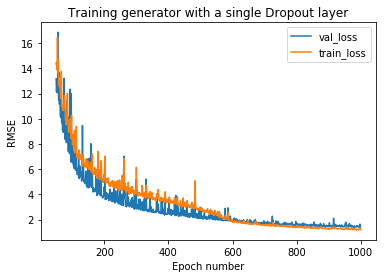

In [27]:
Image('pics/model_dropout.png')

In [28]:
model_dropout.load_weights('weights/dropout_before_flatten.h5')
train_error, dev_error, test_error = prediction_errors_with_test(model_dropout)

Train RMSE: 0.5658935040112145
Dev RMSE: 1.0484194961623288
Test RMSE: 1.2420748329140443


As can be seen above, our train/dev error gap has closed from being >1RMSE to to <0.5 RMSE. The train/test gap is also smaller with this model, indicating we are getting better generalization. In order to improve the model further, we sought to somehow utilize our partially labeled data set, which will be decreased below.

## Augmented Data Model 3 including Partialy Labeled Data

With dropout and augmented dev, both test RMSE and dev RMSE has improved significantly. At this point, we measured our performance on Kaggle again, and received a score of 2.54. This is an improvement from the model without dropout and augmented dev set. In order to further improve the model, we considered how we might use the partially labeled data.

### Preparing Partially Labelled Data

In order to see if we can get a further improvement by incorporating partially labeled images, we first prepare these images and preprocess them in the same way as our previous data. We will also generate an example image from this set as well as the labels.

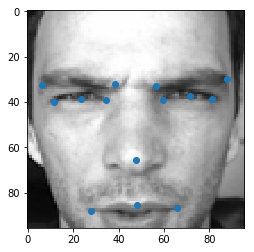

In [32]:
#Prepare partially labeled data from the initial data object
_ = data.train_dev_test_process()
partial_train, partial_labels = data.prepare_partial_data()

partial_predictions = model_dropout.predict(np.expand_dims(partial_train, axis = 3))

plt.imshow(partial_train[5], cmap = 'gray')
plt.scatter(*partial_labels.iloc[5,:].values.reshape(-1,2).T)

To see how our model performs on the partially labeled data, we first predict on the images, and evaluate visually the performance.

[1238 3093 3972  221  643 3490 4048 2531 4280 2854 2232  432 2059   48
 4145 1819 2829  472 3557  154 1062 4821 3869 1903 2519]


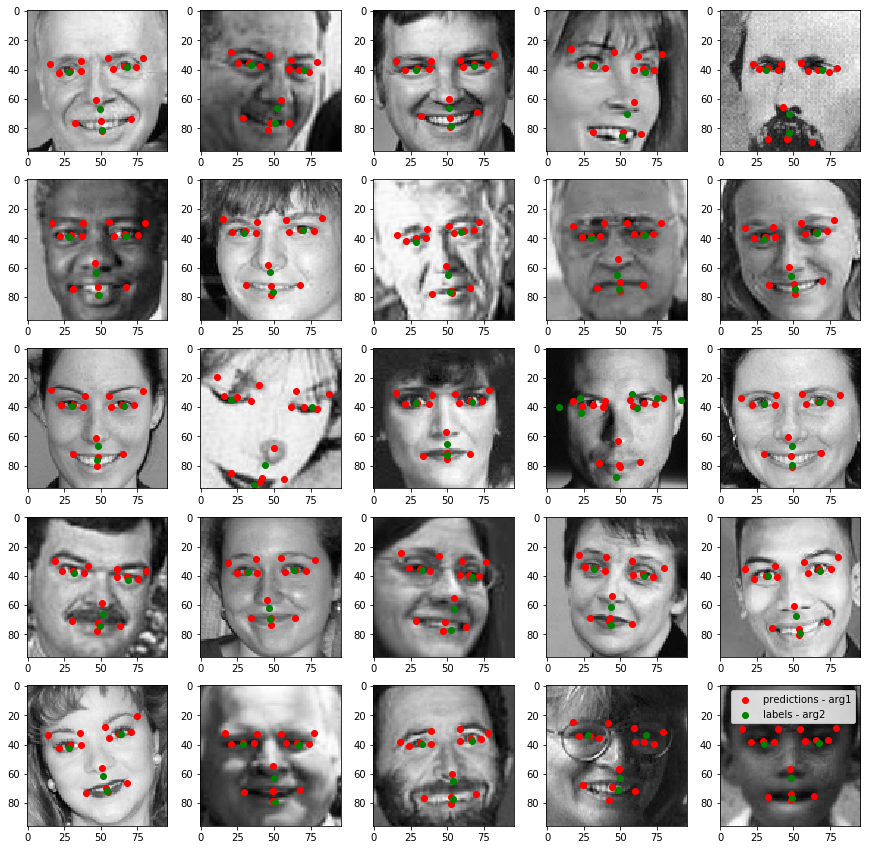

In [35]:
#Show predictions overlaid with partial image locations
c = np.random.choice(np.arange(0,len(partial_predictions)), 25, replace = False)
print(c)
plot_train_data_errors(partial_train[c], partial_predictions[c], partial_labels.values[c], True)

We see that for some of the images, our model performs very well. An example of this includes row 4, last image. What's also true is that when our model performs well, the RMSE between our predicted labels and the partial set of existing labels tend to overlap very well. This gave us the idea of the the following iterative algorithm. The idea to first measure model performance on each image from the partial labels, and for images where the model is performing well, fill in the rest of the labels with the model prediction.

1.   Using the dropout model, predict on partially labeled images
2.   Take only images for which RMSE between the provided partial labels and the corresponding predicted labels is low. 
3.   Reconstruct these images such that we first keep the provided labels, and use the predicted labels for the rest of the keypoints which were not supplied.
4.   Further refine and train the network using early stopping.



The following code chunk demonstrates this process.

In [36]:
#Get rmses based on existing data points
def rmse_row(row, prediction):
    index = np.arange(len(row))[row.notna()]
    return mean_squared_error(row[index], prediction[index])

def rmse_output(labels, predictions, rmse_cutoff = 1):
    rmses = []
    for i,row in labels.reset_index(drop=True).iterrows():
        rmse = rmse_row(row, predictions[i])
        rmses.append(rmse)
    return np.array(rmses)

def reconstruct_partial_train(labels, predictions):
    '''
    This function will produce fully labeled images by taking existing partial labels,
        and filling them in with the labels predicted by a model
    '''
    new_labels = np.zeros(labels.shape)
    for j, label in enumerate(labels):
        new_label = np.array([list(label)[i] or list(predictions[j])[i] for i in np.arange(len(label))])
        new_labels[j, :] = new_label
    return np.array(new_labels)

def gen_new_data(partial_labels, partial_predictions, rmse = 2.5):
    '''
    This function will calculate the iterative algorithm above, and produce fully labeled images
        from the partially labeled images supplied to us.
    '''
    rmses = rmse_output(partial_labels, partial_predictions)
    indices = rmses <= rmse

    labels_selected = partial_labels[indices].fillna(0).values
    predictions_select = partial_predictions[indices]

    augmented_train = partial_train[indices]
    augmented_labels = reconstruct_partial_train(labels_selected, predictions_select)

    return augmented_train, augmented_labels


### Model Training

The following code will describe the model training process.

In [37]:
#Early stopping for each model. This step is important because we will iteratively 
#    generate new data from the partially labeled data set, and will not want to train a model 
#    for too long if the dev score is not improving. We would rather increase the number of iterations.
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=30, verbose=0, mode='auto', restore_best_weights=True)

def augment_from_partial_then_train(model):
    
    #Get partial predictions 
    partial_predictions = model_augmented.predict(np.expand_dims(partial_train, axis = 3))
    
    #Get the good prediction at RMSE 2.5
    #2.5 was a good RMSE. This is a hyperparameter that was tuned.
    predicted_good_train, predicted_good_labels = gen_new_data(partial_labels, partial_predictions, rmse = 2.5)

    #Augment the newly labeled images
    new_train_data = predicted_good_train[:, :, np.arange(0,96,1)[::-1]]
    new_train_labels = np.zeros(predicted_good_labels.shape)

    #new order of the label pairs; right eye becomes left eye, etc.
    new_order = np.array([1, 0, 4, 5, 2,
                      3, 8, 9, 6, 7,
                      10, 12, 11, 13, 14])

    for i,label in enumerate(predicted_good_labels):
        new_label_x = 96 - label.reshape(15,2).T[0][new_order]
        new_label_y = label.reshape(15,2).T[1][new_order]
        new_label = np.vstack([new_label_x, new_label_y]).T.ravel()
    
        new_train_labels[i] = new_label

    predicted_good_train_augmented = np.vstack([predicted_good_train, new_train_data])
    predicted_good_labels_augmented = np.vstack([predicted_good_labels, new_train_labels])
    
    train_data_augmented_partial = np.vstack([train_data_augmented, predicted_good_train_augmented])
    train_labels_augmented_partial = np.vstack([train_labels_augmented, predicted_good_labels_augmented])

    #Shuffle the indices so that the partially labeled images are not all clumped at the end
    shuffle = np.random.permutation(np.arange(len(train_data_augmented_partial)))
    train_data_augmented_partial = train_data_augmented_partial[shuffle]
    train_labels_augmented_partial = train_labels_augmented_partial[shuffle]
    print("Size of the training set: %d" %train_data_augmented_partial.shape[0])
    
    
    #Train the existing model further with this newly augmented dataset with EarlyStopping
    #We tried training a new model each time (with randomly initialized weights), but this took too long
    #We find that iteratively training the same model with newly generated images worked just fine
    training_history = model.fit(train_generator(train_data_augmented_partial, train_labels_augmented_partial),
                             validation_data = (new_dev_data_augmented, new_dev_labels_augmented),
                             epochs=500,
                             steps_per_epoch = np.ceil((train_data_augmented_partial.shape[0]/128)).astype(int),
                             callbacks = [EarlyStop])
    
    aug_cnn_dev_errors = prediction_errors_with_test(model)
    plt.plot(training_history.history['val_loss'][:], label = 'val_loss')
    plt.plot(training_history.history['loss'][:], label = 'train_loss')
    plt.legend()
    plt.show()
    return (model, training_history)

In [38]:
#Training path
#Code will not be run each time
#Performed 20 iterations of the algorithm decribed above
#Saved the best validation score of each model

# size = 20 
# training_histories = []
# models = [model_lenet_inspired_dropout() for i in range(size)]
# for r in range(size):
#     model_augmented, training_history = augment_from_partial_then_train(model_augmented)
#     training_histories.append(training_history)
#     models[r].set_weights(model_augmented.get_weights())

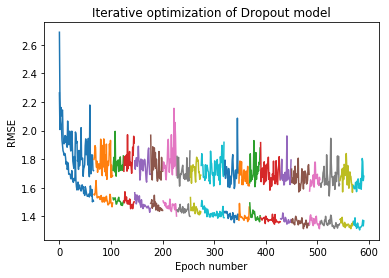

In [40]:
ind_start = 0

#Training history has been saved for the iterative dropout model
#We will plot this below
with open('pics/dropout_training_history.csv', 'r') as f:
    f.readline()
    for line in f:
        line = ','.join(line.split(',')[1:])
        dat = eval(eval(line)[0])
        dat2 = eval(eval(line)[1])
        p = plt.plot(list(range(ind_start, len(dat) + ind_start)), dat, label = 'train_loss')
        color = p[0].get_color()
        plt.plot(list(range(ind_start, len(dat2) + ind_start)), dat2, label = 'val_loss', c = color)
        ind_start += len(dat)
    plt.xlabel('Epoch number')
    plt.ylabel('RMSE')
    plt.title('Iterative optimization of Dropout model')
    
#Note that training error is the bottom line, dev error the top (higher error during training)

In [41]:
model_iterative = model_dropout_before_flatten()
model_iterative.load_weights('weights/final.h5')

train_error, dev_error, test_error = prediction_errors_with_test(model_iterative)

Train RMSE: 0.7027135351361512
Dev RMSE: 1.1680668746014964
Test RMSE: 1.3716274702488782


At this point, we measured our performance on Kaggle again, and received a test RMSE of 1.678, which puts us in **7th place** for the competition. Generalization is also much better for this model, as we only lost ~0.3 RMSE going from our holdout test set to the Kaggle dataset.

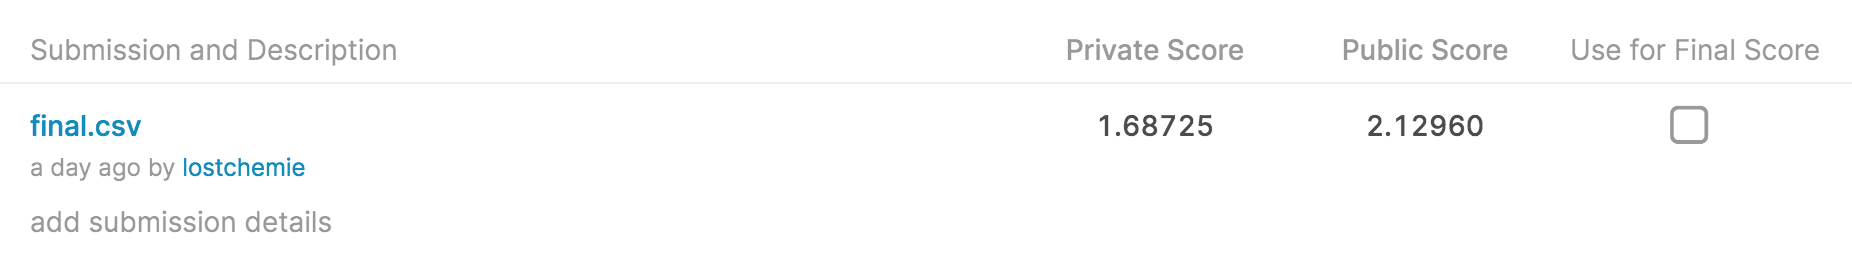

In [42]:
Image('pics/before_transfer_learning_final.png')

## Cross Validation

In this approach, we split full labeled data into 10 partitions and apply cross validation on them. At the end of train, we have 10 models ready. To predict, we run test data forward through 10 models and take average of each label as our final result.


In [130]:
def do_augmentation(X_train, y_train):
    seq = iaa.Sequential([
        iaa.SomeOf((1,2),[
            iaa.Identity(),
            iaa.AverageBlur(k=(2, 5)),
            iaa.Rotate((-30,30)),
            iaa.Affine(
                scale=(0.7, 1.1)
            ),    
            iaa.Multiply((0.5, 1.5))])
    ])
    X_train_aug = np.zeros((X_train.shape))
    y_train_aug = np.zeros((y_train.shape))

    for i in range(len(X_train)):
        kps = KeypointsOnImage.from_xy_array(y_train[i].reshape(-1,2), shape=X_train[i].shape)
        image_aug, kps_aug = seq(image=X_train[i].astype('float32'), keypoints=kps)
        X_train_aug[i] = image_aug
        y_train_aug[i] = kps_aug.to_xy_array()
    return X_train_aug, y_train_aug

def generator(features, labels, batch_size):
    # create empty arrays to contain batch of features and labels
    labels_reshaped = labels.reshape(len(labels), -1,2)
    
    # convert labels to keypoints
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
        # Perform the exactly the same augmentation for X and y
        random_augmented_images, random_augmented_labels = do_augmentation(features[indexes], labels_reshaped[indexes])
        
        # Transform X and y
        X_aug = random_augmented_images
        y_aug = random_augmented_labels.reshape(batch_size,-1)
        yield X_aug, y_aug

def build_model():
    model = Sequential()
    # input layer
    model.add(Conv2D(16, (5, 5), kernel_initializer='he_normal', padding='same', input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    # layer 2
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    # layer 3
    model.add(Conv2D(64, (1, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())

    model.add(Dense(30))
    return model


np.random.seed(42)
foldername = 'result'
os.makedirs(foldername, exist_ok=True)

data = pd.read_csv('training.zip')

#Images to skip
mask = np.array([1877, 1907, 1747, 1995, 1919, 1912, 1926, 2194, 2199, 2202, 1738, 2289, 2321, 2461, 1956, 1741])
full_labels = data.drop(mask).dropna()

#Shuffle images
#np.random.shuffle(full_labels)

#Pre-process images
X_raw = np.stack([np.array(string.split(' ')).reshape(96,96) for string in full_labels['Image']]).astype(np.float)[:, :, :, np.newaxis]
y_raw = np.vstack(full_labels[full_labels.columns[:-1]].values)
X_norm = X_raw / 255.


one_part = len(X_raw)//10
indices = np.arange(X_raw.shape[0])
np.random.shuffle(indices)

batch_size = 128
epochs = 2
adam = optimizers.Adam(learning_rate=0.001, decay = 1e-6)

history = []
for idx in range(10):
    model = build_model()
    # Train
    model.compile(optimizer=adam, loss='mse', metrics=['mae'])

    #Split data
    pos_idx_1 = idx * one_part
    pos_idx_2 = (idx+1) * one_part
    test_imgs = np.zeros(len(X_raw))
    test_imgs[pos_idx_1:pos_idx_2] = 1

    #split image
    test_mask = np.array(test_imgs, dtype='bool')
    #print(np.sum(test_mask))
    X_test = X_norm[indices[test_mask]]
    y_test = y_raw[indices[test_mask]]
    train_mask = np.array(1-test_imgs, dtype='bool')
    #print(np.sum(train_mask))
    X_train = X_norm[indices[train_mask]]
    y_train = y_raw[indices[train_mask]]
    #TO be able to use augmentation, we need to convert image 3D
    #Save model
    #print("=======================Iteration {}=======================".format(idx))
   
    #history= model.fit(generator(X_train, y_train, batch_size),  
                        shuffle=True,  
                        validation_data = (X_test, y_test),
                        epochs=epochs,steps_per_epoch=200,
                        verbose = True)
    #model.save('CV_{}.h5'.format(idx))


=======================Iteration 0=======================
Train for 200 steps, validate on 213 samples
Epoch 1/10
200/200 [==============================] - 46s 230ms/step - loss: 156.5888 - mae: 7.8822 - val_loss: 111.1938 - val_mae: 9.2872
Epoch 2/10
200/200 [==============================] - 45s 224ms/step - loss: 10.2923 - mae: 2.3493 - val_loss: 88.1757 - val_mae: 8.4178
Epoch 3/10
200/200 [==============================] - 45s 225ms/step - loss: 7.5827 - mae: 1.9899 - val_loss: 57.4268 - val_mae: 6.7688
Epoch 4/10
200/200 [==============================] - 45s 224ms/step - loss: 6.6406 - mae: 1.8508 - val_loss: 55.5637 - val_mae: 6.6872
Epoch 5/10
200/200 [==============================] - 45s 225ms/step - loss: 6.0558 - mae: 1.7595 - val_loss: 48.5072 - val_mae: 6.2676
Epoch 6/10
200/200 [==============================] - 45s 226ms/step - loss: 5.6026 - mae: 1.6897 - val_loss: 50.1122 - val_mae: 6.3465
Epoch 7/10
200/200 [==============================] - 45s 225ms/step - loss: 

One drawback for Cross Validation for this project is that we can only train on full labels. Based on the previous analysis on the distribution of the labels, full labels can only present a subset of the complete dataset. This means the CV will likely generate a biased model that only performs well for some face images.

## More Error Analysis

As we experiment with different algorithms and techniques, we started to realize we need to be able to further analyze errors. We started by plotting the distribution of errors by label.

In [46]:
def show_top_10_error(model , X, y, column_headers):
    pred = model.predict(X)
    xy_predictions = pred.reshape(-1,15, 2)
    xy_true = y.reshape(-1,15, 2)
    
    #calculate mae between pred and y
    mae = np.mean(np.abs(y-pred),axis=1)
    print('Mean Error: {}'.format(np.mean(mae)))
    best10_mae = mae.argsort()[:10]
    top10_mae = mae.argsort()[-10:]
    print("Top 10 Errors: ")
    print(top10_mae)
    
    
    #Visual top 10 worst prediction
    fig, axes = plt.subplots(figsize=(20,20),nrows=3, ncols=5)
    #Show top 10 result
    for (err,ax) in zip(top10_mae, axes.ravel()):
        img_mae = np.mean(np.abs(xy_true[err]-xy_predictions[err]))
        #plt.text(str(img_mae))
        ax.set_title('ID:{} MAE:{:.2f}'.format(err,img_mae))
        #plt.subplot(1,10,i+1)
        pred_pos = xy_predictions[err]

        ax.plot(pred_pos[:,0], pred_pos[:,1], 'ro')
        true_pos = xy_true[err]
        ax.plot(true_pos[:,0], true_pos[:,1], 'b*')
        ax.imshow(X[err,:,:,0], cmap='gray')
        ax.axis('off')


    error = pd.DataFrame(np.abs(xy_predictions.reshape(-1,30)-y), columns = column_headers)
    
    ax = plt.subplot(313)
    chart = sns.boxplot(x='variable', y='value', data=pd.melt(error, value_vars=error.columns))
    ax.set_xlabel('')
    ax.set_ylabel('Error', fontsize=12)    
    ax.set_title("Error by position", fontsize=15)
    noret = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    return xy_predictions,error

Mean Error: 0.6376791373159151
Top 10 Errors: 
[ 90  39 151  47  81  69  79 143  32 146]


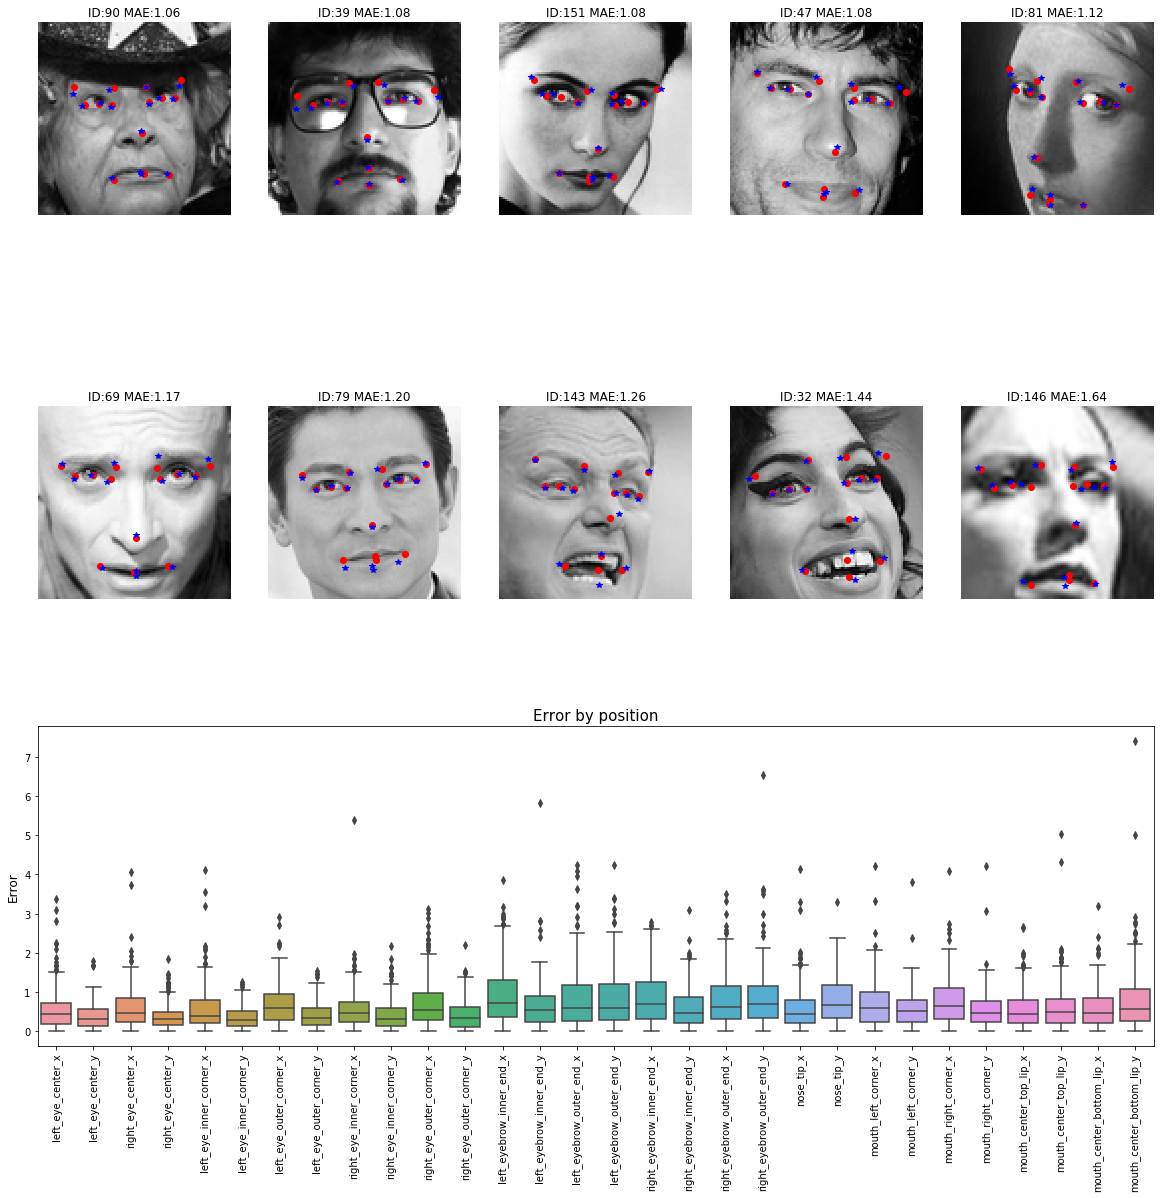

In [50]:
xy_predictions, error = show_top_10_error(model,X_test, y_test,data.columns[:30])

Breaking down for each label allows us to understand better where our model are not doing well. To further understand the potential cause of the larger errors, we plot one of the largest error for each label:
<img src="https://img.techpowerup.org/200411/largeerror.png" style="height:200px"> 

In [133]:
def show_high_error_label_grayscale(X_test, y_test, error, data,model):
    nrows = 6
    ncols = 5
    startIdx = 0
    fig, axes = plt.subplots(figsize=(20, 20), nrows=nrows, ncols=ncols)

    high_error = []
    for pos in data.columns[:30]:
        for i in range(len(error)):
            if error[pos].iloc[i] == max(error[pos]):
                high_error.append(i)
    print(high_error)
    for img, kp, ax, i in zip(X_test[high_error, :, : ], y_test[high_error], axes.ravel(), range(30)):
        pred = model.predict(img.reshape(1,96,96,1)).reshape(30)
        ax.imshow(img.reshape(96,96)/255., cmap='gray')
        err = np.abs(kp[i]-pred[i])
        pos_x = i//2
        pred = pred.reshape(15,2)
        ax.set_title('{}:{:3.1f}'.format(data.columns[i], err))
        kp_pair = kp.reshape(15,2)
        ax.plot(kp_pair[:,0], kp_pair[:,1], 'b.')
        ax.plot(pred[:,0], pred[:,1], "r.")
        ax.plot(kp_pair[pos_x,0], kp_pair[pos_x,1], color='cyan',marker='^')
        ax.plot(pred[pos_x,0], pred[pos_x,1], 'g^')
        ax.axis('off')

[116, 64, 146, 64, 56, 64, 64, 64, 146, 64, 64, 81, 99, 64, 116, 146, 141, 64, 50, 64, 143, 81, 209, 49, 37, 49, 32, 81, 32, 81]


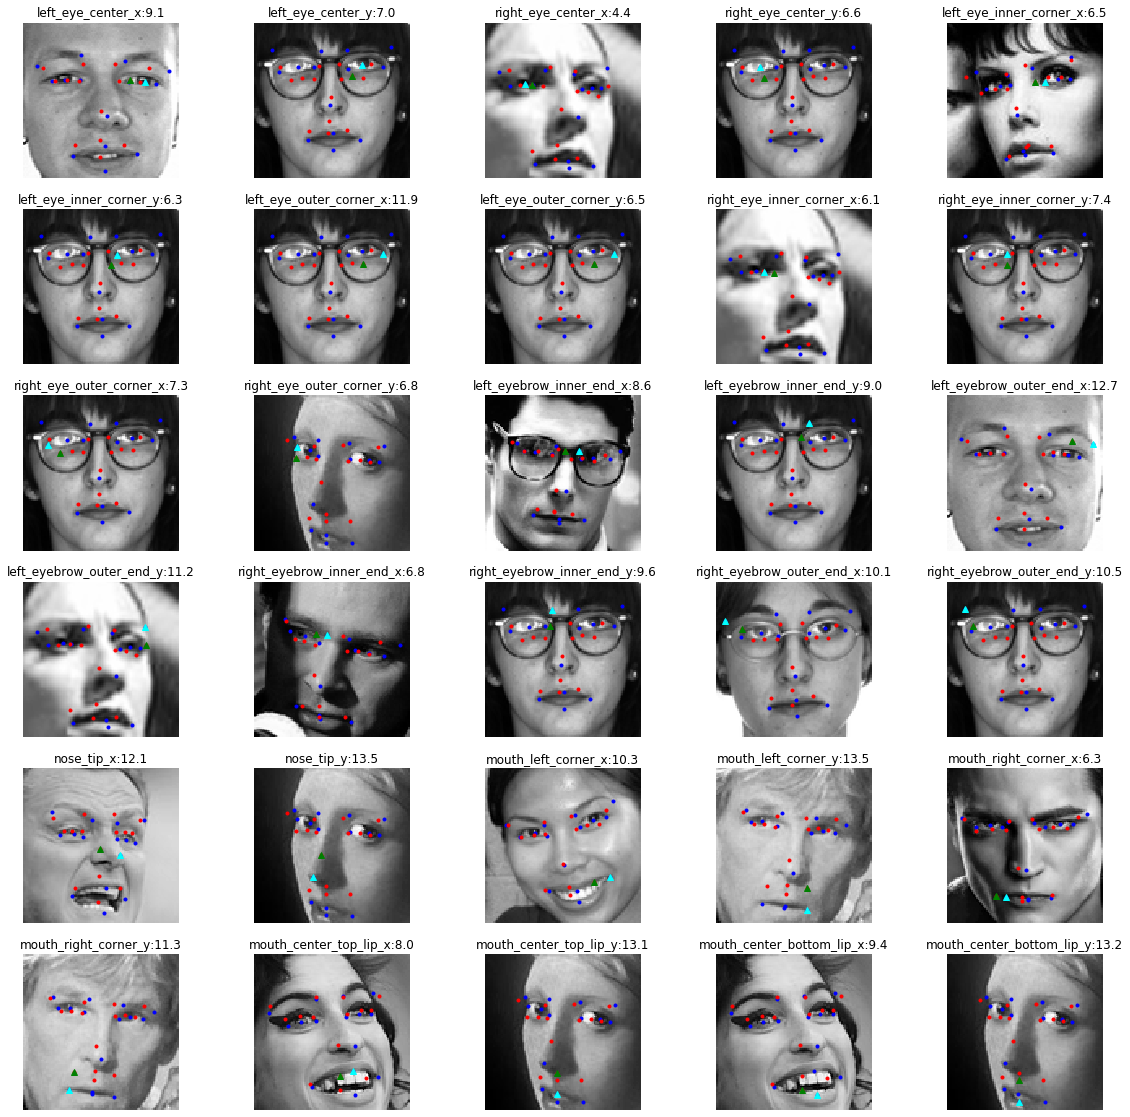

In [134]:
show_high_error_label_grayscale(X_test, y_test, error, data,model)

### Final Result for Cross Validation - Kaggle Score 2.89 (Public)
<img src="https://img.techpowerup.org/200411/cross-validation.png" style="height:200px"> 

## Transfer Learning

We have also experimented with Transfer Learning from trained models. We had experimented with VGG-16, VGG-19 and DenseNet-201. 

DenseNet-201 showed the best Kaggle Result with publich score 2.34 and private score 2.35.

The benefit of using TL is by reusing pre-trained model, it reduces training time. 

However, as we experiment further, we started experience performance bottleneck - pretrained model requires 3 dimensional images and we had to convert the grayscale images to RGB images by replicating the images in 3 channels. Not only it wastes parameters, but also slow down the training in longer term. 

In this experiment, we followed 3-step EM approach:
1. Load pretrained model without header and add 30 unit vector
2. Freeze pretrained layers and train header only
3. Train all layers with full label images
4. Train all layers with all images
5. Apply EM process: 

    5.1 Predict training images and generate our own labels 
    
    5.2 Overwrite our labels with provided training labels 
    
    5.3 Use labels generate in previous step as training data and train model 
    
    5.4 repeat 5.1 - 5.3 until convergence

In [135]:
#Get full label dataset
full_labels = data.drop(mask).dropna()

#Get non-full labelled dataset
full_label_indices = data.index.isin(full_labels.index)
partial_labeled = data[~full_label_indices]

#Prepare training data for baseline
X_raw = np.stack([np.array(string.split(' ')).reshape(96,96) for string in full_labels['Image']]).astype(np.float)[:, :, :, np.newaxis]
y_raw = np.vstack(full_labels[full_labels.columns[:-1]].values)

# Split traing and validation set
np.random.seed(42)
X_norm = X_raw / 255.

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_raw, test_size=0.1)

#Convert to 3d for pretrained network
X_train_3d = np.repeat(X_train[...], 3, -1)   
X_test_3d = np.repeat(X_test[...], 3, -1)  


#Prepare 2nd set of training data (partially labelled)
X2_raw = np.stack([np.array(string.split(' ')).reshape(96,96) for string in partial_labeled['Image']]).astype(np.float)[:, :, :, np.newaxis]
y2_raw = np.vstack(partial_labeled[partial_labeled.columns[:-1]].values)
X2_norm = X2_raw / 255.
X2_3d = np.repeat(X2_norm[...], 3, -1)

In [136]:
base_model = applications.DenseNet201(weights='imagenet',include_top=False, input_shape = (96,96,3))

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(30)(x)
x = LeakyReLU(alpha=0.3)(x)

model = Model(inputs=base_model.input, outputs=x)
#model.summary()

In [137]:
adam = optimizers.Adam(learning_rate=0.0001, decay = 1e-7)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)


# Warm the head
epochs = 5

adam = optimizers.Adam(learning_rate=0.001, decay = 1e-7)
model.compile(optimizer=adam, loss='mse', metrics=['mae'])
X_test_3d = np.repeat(X_test[...], 3, -1)    


history = model.fit(generator(X_train_3d, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (X_test_3d, y_test),
                    epochs=epochs,steps_per_epoch=100
                   )


Train for 100 steps, validate on 214 samples
Epoch 1/5
100/100 [==============================] - 71s 709ms/step - loss: 244.9869 - mae: 10.5202 - val_loss: 1076.1710 - val_mae: 31.0601
Epoch 2/5
100/100 [==============================] - 48s 479ms/step - loss: 54.2342 - mae: 5.3870 - val_loss: 1679.7439 - val_mae: 38.0459
Epoch 3/5
100/100 [==============================] - 48s 479ms/step - loss: 36.0166 - mae: 4.3907 - val_loss: 1698.1933 - val_mae: 37.3833
Epoch 4/5
100/100 [==============================] - 48s 480ms/step - loss: 27.7345 - mae: 3.8607 - val_loss: 1568.8542 - val_mae: 35.5741
Epoch 5/5
100/100 [==============================] - 48s 481ms/step - loss: 23.2986 - mae: 3.5529 - val_loss: 1429.3500 - val_mae: 34.0546


In [138]:
# Open all layers
for layer in base_model.layers:
    layer.trainable = True

epochs = 10
history = model.fit(generator(X_train_3d, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (X_test_3d, y_test),
                    callbacks = [early_stop],                        
                    epochs=epochs,steps_per_epoch=100
                   )

Train for 100 steps, validate on 214 samples
Epoch 1/20
100/100 [==============================] - 48s 478ms/step - loss: 20.6906 - mae: 3.3370 - val_loss: 1366.5944 - val_mae: 33.2183
Epoch 2/20
100/100 [==============================] - 48s 482ms/step - loss: 18.5141 - mae: 3.1730 - val_loss: 1232.1887 - val_mae: 31.2980
Epoch 3/20
100/100 [==============================] - 48s 480ms/step - loss: 16.7402 - mae: 3.0228 - val_loss: 1131.8334 - val_mae: 29.9295
Epoch 4/20
100/100 [==============================] - 48s 483ms/step - loss: 15.8723 - mae: 2.9345 - val_loss: 1080.9481 - val_mae: 29.3579
Epoch 5/20
100/100 [==============================] - 48s 484ms/step - loss: 14.5328 - mae: 2.8119 - val_loss: 1049.3734 - val_mae: 28.8232
Epoch 6/20
100/100 [==============================] - 48s 482ms/step - loss: 14.0057 - mae: 2.7617 - val_loss: 967.0727 - val_mae: 27.6695
Epoch 7/20
100/100 [==============================] - 48s 481ms/step - loss: 13.1368 - mae: 2.6776 - val_loss: 944.6

In [139]:
# EM method for all images
model.compile(optimizer=adam, loss='mse', metrics=['mae'])
X_test_3d = np.repeat(X_test[...], 3, -1)    

#Save mse
last_mse = np.inf  

# Termination Threshold 
epsilon = 0.0005

foldername = "TL_models"
os.makedirs(foldername, exist_ok=True)
model.save('{}/EM_base.h5'.format(foldername))

iter = 1
while True:
    print("==========Iteration {}===================".format(iter))
    #1 Predict 
    y2_pred = model.predict(X2_3d)
    
    #2 Update labels
    y2_new = y2_raw.copy()
    mask = np.isnan(y2_raw)
    y2_new[mask] = y2_pred[mask]

    #3 Merge data set together
    X_new = np.append(X_train_3d, X2_3d,axis=0)
    y_new = np.append(y_train, y2_new, axis=0)
    
    #4 Train again
    model.fit(generator(X_new, y_new, batch_size),  
                    shuffle=True,  
                    validation_data = (X_test_3d, y_test),
                    callbacks = [early_stop],                        
                    epochs=epochs,steps_per_epoch=20
                   )
    mse = model.evaluate(X_test_3d, y_test)[0]

    model.save('{}/TL_Iter_{:04d}_{}.h5'.format(foldername,iter, mse))
    iter += 1
    if (last_mse - mse < epsilon):
        break;
    last_mse = mse

==========Iteration 1===================
Train for 20 steps, validate on 214 samples
Epoch 1/20
20/20 [==============================] - 65s 3s/step - loss: 328.5707 - mae: 11.9340 - val_loss: 5986334148752438099091412609925120.0000 - val_mae: 71536902267731968.0000
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 109.6582 - mae: 7.7436 - val_loss: 27257345210623685820416.0000 - val_mae: 99124092928.0000
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 109.2327 - mae: 7.6197 - val_loss: 82271218238052.4844 - val_mae: 8294547.0000
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 94.1469 - mae: 7.1554 - val_loss: 2761534688.8972 - val_mae: 47854.6016
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 82.9815 - mae: 6.6822 - val_loss: 12285339.9346 - val_mae: 2873.4185
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 81.3554 - mae: 6.6174 - val_loss: 83596.1218 - val_mae: 209.9

==========Iteration 2===================
Train for 20 steps, validate on 214 samples
Epoch 1/20
20/20 [==============================] - 23s 1s/step - loss: 30.6518 - mae: 3.6390 - val_loss: 109.9831 - val_mae: 7.2762
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 27.3577 - mae: 3.3225 - val_loss: 40.4087 - val_mae: 3.8499
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 25.1945 - mae: 3.1233 - val_loss: 100.0669 - val_mae: 6.5092
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 30.0545 - mae: 3.5882 - val_loss: 95.5844 - val_mae: 6.7805
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 27.0203 - mae: 3.3054 - val_loss: 108.1144 - val_mae: 7.2080
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 24.0004 - mae: 3.1001 - val_loss: 110.3944 - val_mae: 7.5576
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 23.5757 - mae: 3.0646 - val_loss: 49.2984 - val

==========Iteration 3===================
Train for 20 steps, validate on 214 samples
Epoch 1/20
20/20 [==============================] - 23s 1s/step - loss: 18.3394 - mae: 2.9533 - val_loss: 13.7323 - val_mae: 2.5868
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 14.5614 - mae: 2.5098 - val_loss: 15.0093 - val_mae: 2.6504
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 14.5337 - mae: 2.4342 - val_loss: 15.1762 - val_mae: 2.6406
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 12.1705 - mae: 2.3149 - val_loss: 16.3748 - val_mae: 2.7162
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 12.4652 - mae: 2.2970 - val_loss: 14.5518 - val_mae: 2.6023
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 12.3287 - mae: 2.3391 - val_loss: 18.0535 - val_mae: 2.8445
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 12.2033 - mae: 2.3147 - val_loss: 16.4708 - val_mae

==========Iteration 4===================
Train for 20 steps, validate on 214 samples
Epoch 1/20
20/20 [==============================] - 23s 1s/step - loss: 9.6692 - mae: 2.0779 - val_loss: 13.8577 - val_mae: 2.5139
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 9.2512 - mae: 1.9863 - val_loss: 24.2152 - val_mae: 3.3945
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 9.1813 - mae: 1.9617 - val_loss: 14.0587 - val_mae: 2.5193
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 8.2850 - mae: 1.8876 - val_loss: 13.9048 - val_mae: 2.5323
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 8.2435 - mae: 1.9156 - val_loss: 11.7705 - val_mae: 2.3629
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 8.4751 - mae: 1.8632 - val_loss: 15.0277 - val_mae: 2.6510
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 8.2887 - mae: 1.9426 - val_loss: 15.4805 - val_mae: 2.590

==========Iteration 5===================
Train for 20 steps, validate on 214 samples
Epoch 1/20
20/20 [==============================] - 23s 1s/step - loss: 7.1485 - mae: 1.7597 - val_loss: 13.0070 - val_mae: 2.4396
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 6.6402 - mae: 1.7010 - val_loss: 7.9486 - val_mae: 1.9691
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 6.8216 - mae: 1.6784 - val_loss: 13.2365 - val_mae: 2.4792
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 6.5750 - mae: 1.7094 - val_loss: 10.2276 - val_mae: 2.1439
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 6.7265 - mae: 1.6996 - val_loss: 15.1517 - val_mae: 2.5331
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 6.3218 - mae: 1.6485 - val_loss: 11.2305 - val_mae: 2.2350
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 6.6223 - mae: 1.7020 - val_loss: 9.7396 - val_mae: 2.1197


In [140]:
def show_high_error_label(X_test_3d, y_test, error, data,model):
    nrows = 6
    ncols = 5
    startIdx = 0
    fig, axes = plt.subplots(figsize=(20, 20), nrows=nrows, ncols=ncols)

    high_error = []
    for pos in data.columns[:30]:
        for i in range(len(error)):
            if error[pos].iloc[i] == max(error[pos]):
                high_error.append(i)
    print(high_error)
    for img, kp, ax, i in zip(X_test_3d[high_error, :, : ], y_test[high_error], axes.ravel(), range(30)):
        pred = model.predict(img.reshape(1,96,96,3)).reshape(30)
        ax.imshow(img, cmap='gray')
        err = np.abs(kp[i]-pred[i])
        pos_x = i//2
        pred = pred.reshape(15,2)
        ax.set_title('{}:{:3.1f}'.format(data.columns[i], err))
        kp_pair = kp.reshape(15,2)
        ax.plot(kp_pair[:,0], kp_pair[:,1], 'b.')
        ax.plot(pred[:,0], pred[:,1], "r.")
        ax.plot(kp_pair[pos_x,0], kp_pair[pos_x,1], color='cyan',marker='^')
        ax.plot(pred[pos_x,0], pred[pos_x,1], 'r^')
        ax.axis('off')

Mean Error: 2.5537425406445555
Top 10 Errors: 
[ 11  29 199   4 163 107  13 133 125 175]


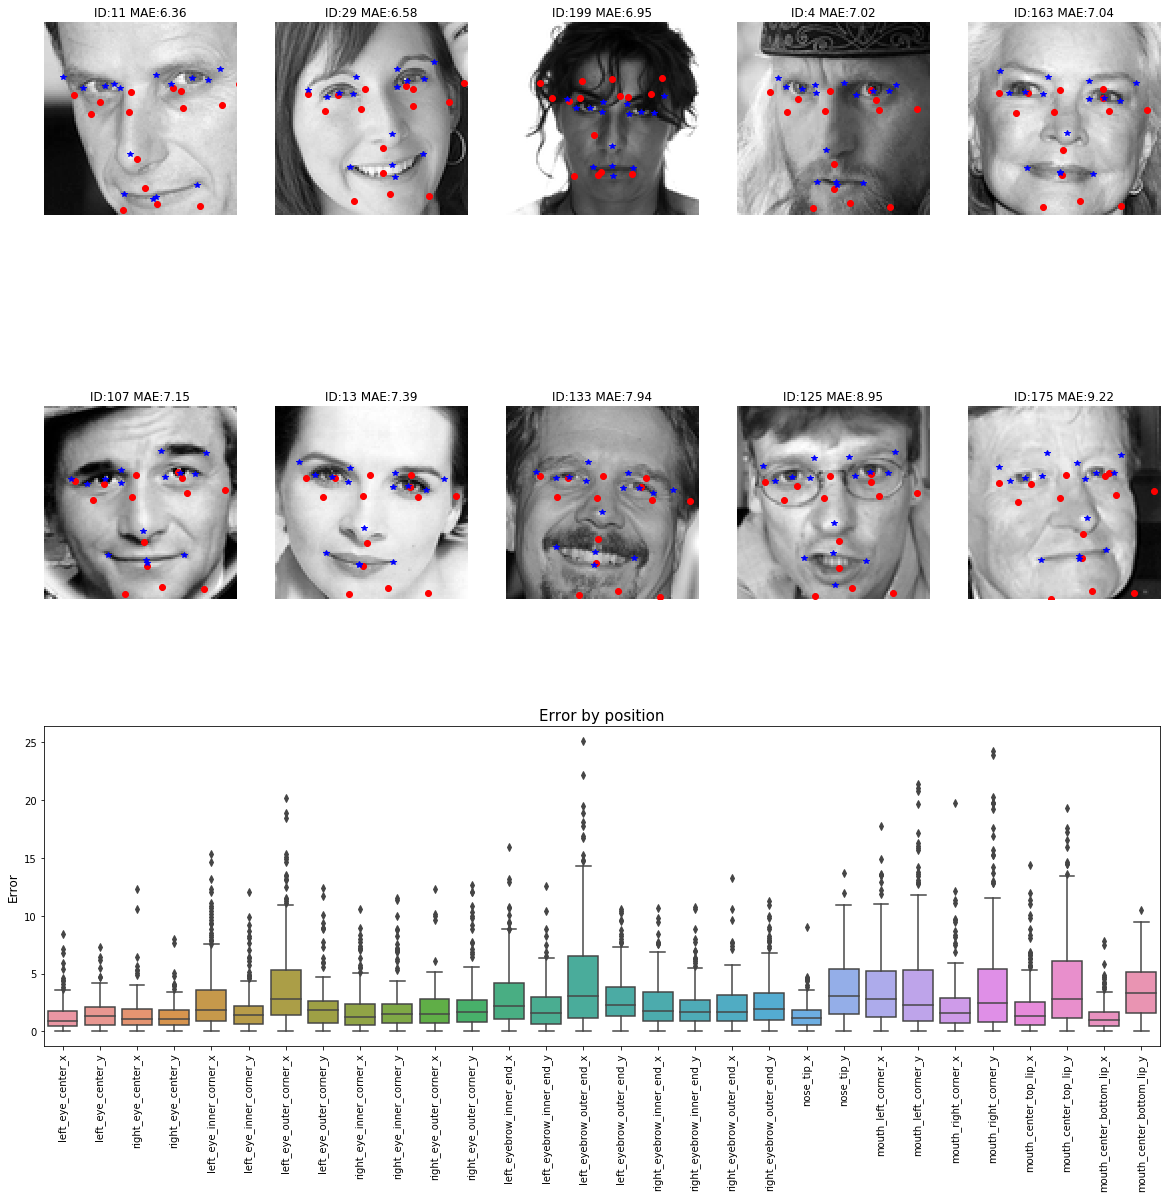

In [141]:
xy_predictions, error = show_top_10_error(model,X_test_3d, y_test,data.columns[:30])

[130, 199, 130, 11, 175, 11, 175, 11, 199, 11, 199, 11, 175, 199, 175, 29, 199, 199, 199, 163, 199, 133, 13, 175, 130, 189, 13, 133, 130, 122]


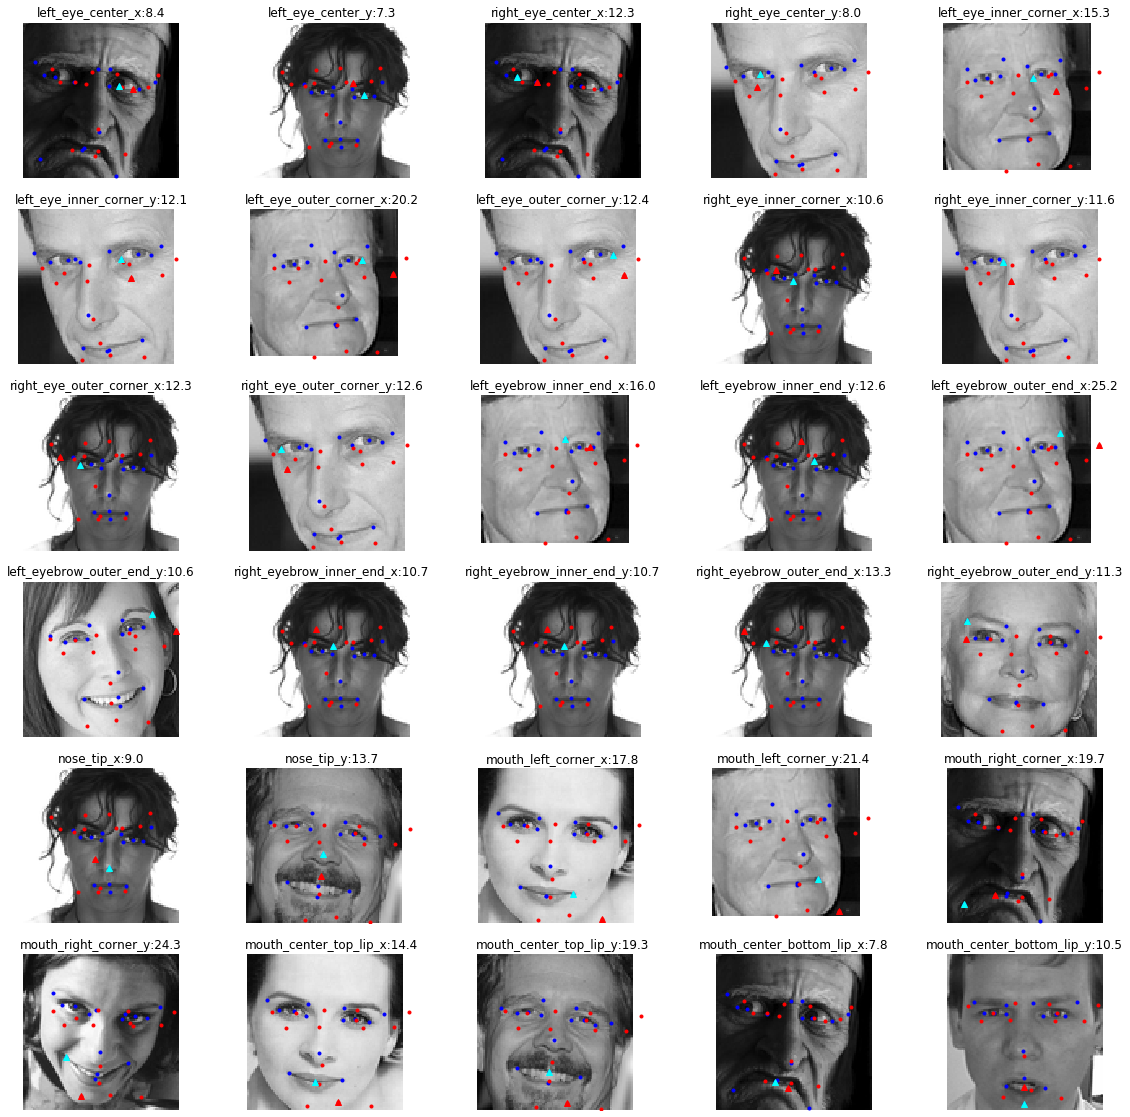

In [142]:
show_high_error_label(X_test_3d, y_test, error, data,model)

### Final Result for Transfer Learning - Kaggle Score: 2.34 (Public)

## Final model: Resnet implementation in grayscale

In our final model, considering the drawback of a pretrained 3 dimensional CNN model, we implemented a grayscale model based on Resnet. This allows us to able to train a larger network with parameters faster (comparing to RGB images). The only downside is we will need to train from begining as we are not able to reuse any existing weights. 

In [143]:
# flip images for full labels
X_flip = X_train[:,:,::-1]
y_flip = y_train[:,[2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]]
y_flip[:,::2] = 96 - y_flip[:,::2]

#merge flip
X_train = np.vstack((X_train, X_flip))
y_train = np.vstack((y_train, y_flip))

#Prepare 2nd set of training data (partially labelled)
X2_raw = np.stack([np.array(string.split(' ')).reshape(96,96) for string in partial_labeled['Image']]).astype(np.float)[:, :, :, np.newaxis]
y2_raw = np.vstack(partial_labeled[partial_labeled.columns[:-1]].values)
#X2_norm = X2_raw #/ 255.
X2_flip = X2_raw[:,:,::-1]
y2_flip = y2_raw[:,[2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]]
y2_flip[:,::2] = 96 - y2_flip[:,::2]
X2 = np.vstack((X2_raw, X2_flip))
y2 = np.vstack((y2_raw, y2_flip))

In [144]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
  
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
   
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=2):

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=256,
                                      min_size=96,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [145]:
base_model = ResNet50(input_shape = [96,96,1], pooling = 'avg', include_top = False)

x = base_model.output
x = Dropout(0.2)(x)
x = Dense(30)(x)

model = Model(inputs=base_model.input, outputs=x)

In [146]:
# Train the network with full labels
adam = optimizers.Adam(learning_rate=0.01, decay = 1e-6)

epochs = 5

model.compile(optimizer=adam, loss='mse',metrics=['mae'])

history = model.fit(generator(X_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (X_test, y_test),                        
                    epochs=epochs,
                    steps_per_epoch=100,
                    verbose=True
                   )
print(model.optimizer.lr)

Train for 100 steps, validate on 214 samples
Epoch 1/5
100/100 [==============================] - 75s 752ms/step - loss: 81.4681 - mae: 4.9949 - val_loss: 6798.8589 - val_mae: 62.6964
Epoch 2/5
100/100 [==============================] - 66s 660ms/step - loss: 18.6695 - mae: 3.1393 - val_loss: 60.2669 - val_mae: 6.9111
Epoch 3/5
100/100 [==============================] - 66s 661ms/step - loss: 12.3089 - mae: 2.6142 - val_loss: 34.8700 - val_mae: 4.9967
Epoch 4/5
100/100 [==============================] - 66s 663ms/step - loss: 9.1659 - mae: 2.2626 - val_loss: 20.8355 - val_mae: 3.7195
Epoch 5/5
100/100 [==============================] - 66s 664ms/step - loss: 7.4673 - mae: 2.0473 - val_loss: 17.3972 - val_mae: 3.3011
<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.01>


In [147]:
# EM method for all images

#Save mse
last_mse = np.inf  #model.evaluate(X_test_3d, y_test)[0]

#Threshold 
patience = 2

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

epochs = 10

foldername = "Resnet_models"
os.makedirs(foldername, exist_ok=True)
model.save('Resnet_models/Resnet_base_{}.h5'.format(last_mse))

iter = 1
while True:
    print("============================= Iteration {:03d} =============================".format(iter))
    #1 Predict 
    model.optimizer.lr =0.001

    y2_pred = model.predict(X2)
    
    #2 Update labels
    y2_new = y2.copy()
    mask = np.isnan(y2)
    y2_new[mask] = y2_pred[mask]

    #3 Merge data set together
    X_new = np.append(X_train, X2,axis=0)
    y_new = np.append(y_train, y2_new, axis=0)
    
    weights_file_name = 'Resnet_models/weights_{:03d}'.format(iter) + '_{epoch:08d}.h5'
    #4 Train again
    model.fit(generator(X_new, y_new, batch_size),  
                    shuffle=True,  
                    validation_data = (X_test, y_test),
                    callbacks = [early_stop],                        
                    epochs=epochs,steps_per_epoch=100
                   )
    mse = model.evaluate(X_test, y_test)[0]

    model.save('Resnet_models/Resnet_Iter_{:04d}_{}.h5'.format(iter, mse))
    iter += 1
    if (last_mse - mse < epsilon):
        no_improve_counter += 1
    else:
        last_mse = mse
        no_improve_counter = 0
        
    print("Best MSE: {:7.5f}, Current MSE: {:7.5f}, Wait:{}".format(last_mse, mse, no_improve_counter))
    if no_improve_counter >= patience:
        break


============================= Iteration 001 =============================
Train for 100 steps, validate on 214 samples
Epoch 1/10
100/100 [==============================] - 66s 663ms/step - loss: 326943.4011 - mae: 291.4485 - val_loss: 146.3529 - val_mae: 9.3298
Epoch 2/10
100/100 [==============================] - 66s 663ms/step - loss: 80473.9934 - mae: 135.2297 - val_loss: 88.4124 - val_mae: 7.6593
Epoch 3/10
100/100 [==============================] - 67s 667ms/step - loss: 78392.7227 - mae: 132.4304 - val_loss: 69.4563 - val_mae: 7.1230
Epoch 4/10
100/100 [==============================] - 66s 665ms/step - loss: 79997.6993 - mae: 130.6586 - val_loss: 66.8746 - val_mae: 7.2678
Epoch 5/10
100/100 [==============================] - 66s 664ms/step - loss: 76277.0812 - mae: 128.1729 - val_loss: 89.7662 - val_mae: 8.6422
Epoch 6/10
100/100 [==============================] - 66s 663ms/step - loss: 73401.9387 - mae: 125.4317 - val_loss: 89.2083 - val_mae: 8.6007
Epoch 7/10
100/100 [=======

100/100 [==============================] - 67s 668ms/step - loss: 44031.9418 - mae: 92.2044 - val_loss: 183.3070 - val_mae: 11.0901
Epoch 2/10
100/100 [==============================] - 67s 668ms/step - loss: 39906.8502 - mae: 83.5969 - val_loss: 34.0575 - val_mae: 4.6541
Epoch 3/10
100/100 [==============================] - 67s 668ms/step - loss: 42581.7150 - mae: 87.7894 - val_loss: 19.4778 - val_mae: 3.1932
Epoch 4/10
100/100 [==============================] - 67s 667ms/step - loss: 40374.1218 - mae: 85.1433 - val_loss: 16.5372 - val_mae: 3.0109
Epoch 5/10
100/100 [==============================] - 67s 665ms/step - loss: 38957.4330 - mae: 83.3362 - val_loss: 21.8184 - val_mae: 3.4601
Epoch 6/10
100/100 [==============================] - 67s 667ms/step - loss: 40125.7179 - mae: 85.1660 - val_loss: 24.0010 - val_mae: 3.9234
Epoch 7/10
100/100 [==============================] - 67s 665ms/step - loss: 38228.0752 - mae: 83.4702 - val_loss: 41.5583 - val_mae: 5.3146
Epoch 8/10
100/100 [==

100/100 [==============================] - 67s 666ms/step - loss: 34440.1095 - mae: 76.8916 - val_loss: 17.4919 - val_mae: 3.2417
Epoch 3/10
100/100 [==============================] - 67s 665ms/step - loss: 35537.6935 - mae: 79.0044 - val_loss: 20.6761 - val_mae: 3.5050
Epoch 4/10
100/100 [==============================] - 67s 666ms/step - loss: 33048.1183 - mae: 75.4149 - val_loss: 53.3342 - val_mae: 5.7140
Epoch 5/10
100/100 [==============================] - 67s 665ms/step - loss: 33425.2239 - mae: 76.4490 - val_loss: 22.4021 - val_mae: 3.7006
Epoch 6/10
100/100 [==============================] - 67s 666ms/step - loss: 33714.5218 - mae: 75.8054 - val_loss: 22.5268 - val_mae: 3.6827
Epoch 7/10
100/100 [==============================] - 66s 665ms/step - loss: 35377.6813 - mae: 79.0846 - val_loss: 22.2448 - val_mae: 3.5317
Epoch 8/10
100/100 [==============================] - 66s 665ms/step - loss: 33735.5178 - mae: 77.7824 - val_loss: 84.5564 - val_mae: 7.6616
Epoch 9/10
100/100 [====

The error analysis shows this model is far from perfect and there are still large errors:

<img src="https://img.techpowerup.org/200411/finalerror.png" style="height:500px"> 

# Final Result

We have built multiple models that are able to enter top 10 positions in Kaggle competition. The best score we have achieved, is lower than #1 in Public Leaderboard:

<img src="https://img.techpowerup.org/200411/1st-place.png" style="height:300px"> 


## Submission to Kaggle

In [173]:
def extract_for_submission(predictions, save = None):
    '''
    This code generates a file that can be submitted to Kaggle
    '''
    columns=['ImageId','FeatureName','Location']
    df_results = pd.DataFrame()

    n = 1
    for i, pred in enumerate(predictions):
        df_results = df_results.append(list(zip(list([n] * len(names)), list(names), pred)))
        n+=1
    df_results.columns = columns
    df_results['RowId'] = np.arange(1, df_results.shape[0]+1)
    df_output = submission_rows.merge(df_results, on=['ImageId', 'FeatureName'], how='inner')

    #Save the results
    df_output = df_output.rename(columns = {'RowId_x':'RowId'})

    if save:
        df_output[['RowId', 'Location']].to_csv(save, index=False)
        drive.flush_and_unmount()

    return df_output

#predictions = model_augmented.predict(np.expand_dims(test_data, axis = 3))
#df_output = extract_for_submission(predictions, 'predictions_augmented.csv')

## Conclusion

Our voyage in predicting keypoint positions on face images started by exploring the input data. Thinking the pixels of an image as features, we wanted to build a model that maps these features to the location of facial landmarks on a continuous scale from 0 - 96, in both the x and y directions. For this, we first trained a collection of baseline models (see Appendix), including k-Nearest Neighbors, Linear Regression, Ridge Regression, Decision Tree Regressor, Random Forest Regressor, Support Vector Regression and Neural Network regression with standard architecture. The common point among these baseline models is that they all operate on a flattened representation of the image features. 

We decided not to spend much time on improving these initial models as we discovered none of them come close to a Convolutional Neural Networks (CNN) architecture in terms of the model performance. Given it's significantly better performance on image based problems, we decided to go with a CNN architecture to capture the features of images, then use linear Regression to output 30 vectors. Accordingly, we allocated most of our efforts to feature engineering and hyperparameter optimization of our CNN architecture to improve it's performance.

In choosing a CNN network, we started with build and training a relatively simple network inspired by LeNet. This architecture was our baseline to test various different data augmentation strategies. Noticing that the training set has a considerable number of poorly labeled images, we decided to focus only on the fully labeled images in early iterations. 

By applying transformations to existing images and then adding them back into the training set, we can artificially increase the diversity of the training set while preserving the keypoints during the transformation. To increase the diversity of the training set, we applied such data augmentation by taking the mirror image of an image across the y-axis to vertically flip it.

After adding the flipped images and increasing the size of the training set, we observed that we were still overfitting although we were successfull at gradually improving the dev and test errors. We believe that this is due to the fact that the data added was static, and with enough epochs, we would still overfit. To mitigate this, we decided to implement further image augmentation by using imgaug, which also keeps keypoints invariant. This allowed us to fit the model by augmenting training data on the fly so that each batch, as well as each epoch, sees differently augmented images. The performance turned out to be fairly good, giving a Kaggle evaluation that returned an RMSE of 2.97. 

To improve the generalization on the Kaggle test set, we tried increasing the diversity of images in the dev set as well with the hope of capturing some of the features in the test set. We also modified the model by adding a Dropout layer between the convolutional layers and the dense layers to further close the gap between the training error and the dev set error. Here we employed an iterative algorithm that trains the model using only the fully labeled images, and uses the dropout model to predict on partially labeled images. The it takes only the images for which RMSE between the provided partial labels and the corresponding predicted labels is low, and reconstructs these images such that we first keep the provided labels, and then use the predicted labels for the rest of the keypoints which were not supplied. Finally it further refines and trains the network using early stopping.

Incorporating this EM algorithm, we also tested several other methodologies such as cross validating with 10 partitions and transfer learning using a pretrained weights from DenseNet 201. In our final model, considering the drawback of a pretrained 3 dimensional CNN model, we implemented a grayscale model based on Resnet. This enabled us to train a larger network with faster parameters when compared to RGB images.

## Appendix

#### Baseline Models

In order to explore other types of models, we will apply every method we've learned in this course that has a natural translation in the regression context. This includes k-Nearest Neighbors, Linear Regression, Ridge Regression, Decision Tree Regressor, and Random Forest Regressor. These models will all operate on a flattened representation of the image as its features, and using the standard scaled images pixels as features.

In [175]:
#Flattened representations
train_data_flattened = train_data.reshape(train_data.shape[0], -1)
dev_data_flattened = dev_data.reshape(dev_data.shape[0], -1)
models = ['kNN Regression', 'Linear Regression', 'Ridge Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Support Vector Regression']
best_rmse = {i:np.Inf for i in models}

#### k-NN Regression

In [176]:
#k-NN Regression with default predictions
kNN_r = KNeighborsRegressor()
kNN_r.fit(train_data_flattened, train_labels)
predictions = kNN_r.predict(dev_data_flattened)
rmse = mean_squared_error(predictions, dev_labels)

In [177]:
#k-NN Regression with GridSearchCV for n_neighbors
params = {'n_neighbors': [1, 3, 5, 10]}

clf = GridSearchCV(kNN_r, params, scoring = 'neg_mean_squared_error')
clf.fit(train_data_flattened, train_labels)
clf.best_params_

{'n_neighbors': 5}

In [178]:
best_rmse['kNN Regression'] = rmse

#### Linear Regression

In [179]:
lr = LinearRegression()
lr.fit(train_data_flattened, train_labels)
predictions = lr.predict(dev_data_flattened)
rmse = mean_squared_error(predictions, dev_labels)
print(rmse)
best_rmse['Linear Regression'] = rmse

6.764651710927456


#### Ridge Regression

In [180]:
#Ridge regression with default alpha
lr_l2 = Ridge()
lr_l2.fit(train_data_flattened, train_labels)
predictions = lr_l2.predict(dev_data_flattened)
mean_squared_error(predictions, dev_labels)

6.025054444452666

In [181]:
#Ridge regression with GridSearchCV over alpha values
params = {'alpha': [0.5, 5, 500, 1500, 2500, 3000]}

clf = GridSearchCV(lr_l2, params, scoring = 'neg_mean_squared_error')
clf.fit(train_data_flattened, train_labels)
clf.best_params_

{'alpha': 500}

In [182]:
#Ridge regression with best alpha
lr_l2 = Ridge(alpha = 2500)
lr_l2.fit(train_data_flattened, train_labels)
predictions = lr_l2.predict(dev_data_flattened)
rmse = mean_squared_error(predictions, dev_labels)
print(rmse)
best_rmse['Ridge Regression'] = rmse

5.614315491912726


#### Decision Tree Regressor

In [183]:
#Default Decision Tree Regressor
dt_r = DecisionTreeRegressor()
dt_r.fit(train_data_flattened, train_labels)
predictions = dt_r.predict(dev_data_flattened)
rmse = mean_squared_error(predictions, dev_labels)
print(rmse)

12.05217278810675


In [184]:
#GridSearchCV over max depth values
params = {'max_depth': [1, 5, 10, 20]}

clf = GridSearchCV(dt_r, params, scoring = 'neg_mean_squared_error', cv = 3)
clf.fit(train_data_flattened, train_labels)
clf.best_params_

{'max_depth': 5}

In [185]:
#Best Decision Tree Regressor
dt_r = DecisionTreeRegressor(max_depth=5)
dt_r.fit(train_data_flattened, train_labels)
predictions = dt_r.predict(dev_data_flattened)
rmse = mean_squared_error(predictions, dev_labels)
print(rmse)
best_rmse['Decision Tree Regression'] = rmse

8.294298999998206


#### Random Forest Regressor

In [186]:
#Try a baseline RF Regressor
rf_r = RandomForestRegressor(max_features = 'sqrt')
rf_r.fit(train_data_flattened, train_labels)
predictions = rf_r.predict(dev_data_flattened)
rmse = mean_squared_error(predictions, dev_labels)
print(rmse)

6.171675747418457


In [187]:
#GridSearchCV over max depth values
params = {'max_features' : ['sqrt'],
         'n_estimators': [100, 200, 250],
         'max_depth': [1, 8, 16],
         'min_samples_split': [2, 0.1, 0.4],
         }

clf = GridSearchCV(rf_r, params, scoring = 'neg_mean_squared_error', cv = 3, verbose=10, n_jobs=-1)
clf.fit(train_data_flattened, train_labels)
clf.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done  79 out of  81 | elapsed:  1.3min remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.3min finished


{'max_depth': 16,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 200}

In [188]:
#Best RF Regressor
rf_r = RandomForestRegressor(**clf.best_params_)
rf_r.fit(train_data_flattened, train_labels)
predictions = rf_r.predict(dev_data_flattened)
rmse = mean_squared_error(predictions, dev_labels)
print(rmse)
best_rmse['Random Forest Regression'] = rmse

5.477444773174011


Overall, these models are not anywhere near the performance of even the baseline CNN, so we did not pursue optimization of any of these models further.